In [2]:
# Imports
import math
import torch
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
# 'text.usetex': True, 'font.family': 'Helvetica'
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

In [3]:
class LNNet(nn.Module):
  """
  A Linear Neural Net with one hidden layer
  """

  def __init__(self, in_dim, hid_dim, out_dim, scale_w1, scale_w2):
    """
    Initialize LNNet parameters

    Args:
      in_dim: int
        Input dimension
      out_dim: int
        Ouput dimension
      hid_dim: int
        Hidden dimension

    Returns:
      Nothing
    """
    super().__init__()
    self.in_hid = nn.Linear(in_dim, hid_dim, bias=False)
    nn.init.normal_(self.in_hid.weight, mean=0.0, std=scale_w1)

    self.hid_out = nn.Linear(hid_dim, out_dim, bias=False)
    nn.init.normal_(self.hid_out.weight, mean=0.0, std=scale_w2)

  def forward(self, x):
    """
    Forward pass of LNNet

    Args:
      x: torch.Tensor
        Input tensor

    Returns:
      hid: torch.Tensor
        Hidden layer activity
      out: torch.Tensor
        Output/Prediction
    """
    hid = F.relu(self.in_hid(x))  # Hidden activity
    # out = F.tanh(self.hid_out(hid))  # Output (prediction)
    out = self.hid_out(hid)  # Output (prediction)
    return out, hid

def initializer_(model, scale_ws):
  """
  In-place Re-initialization of weights

  Args:
    model: torch.nn.Module
      PyTorch neural net model
    gamma: float
      Initialization scale

  Returns:
    Nothing
  """
  for w_i, weight in enumerate(model.parameters()):
    n_out, n_in = weight.shape
    # sigma = gamma / math.sqrt(n_in + n_out)
    nn.init.normal_(weight, mean=0.0, std=scale_ws[w_i])

In [4]:
def train(model, inputs, targets, n_epochs, lr, wd_lambda=0):
  """
  Training function

  Args:
    model: torch nn.Module
      The neural network
    inputs: torch.Tensor
      Features (input) with shape `[batch_size, input_dim]`
    targets: torch.Tensor
      Targets (labels) with shape `[batch_size, output_dim]`
    n_epochs: int
      Number of training epochs (iterations)
    lr: float
      Learning rate
    wd_lambda: float
      Weight-decaying parameters

  Returns:
    losses: np.ndarray
      Record (evolution) of training loss
  """
  losses = np.zeros(n_epochs)  # Loss records
  weight_rel_changes = [np.zeros(n_epochs), np.zeros(n_epochs)]  # Relative changes of weights in input-hidden layer and hidden-output layer

  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd_lambda)
  criterion = nn.MSELoss()

  init_weight_norms = []
  for weight in dlnn_model.parameters():
    init_weight_norms.append(torch.linalg.norm(weight))

  for i in range(n_epochs):
    optimizer.zero_grad()
    predictions, hiddens = model(inputs)
    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()

    # Logging (recordings)
    losses[i] = loss.item()
    # Relative changes in weights
    for w_i, weight in enumerate(model.parameters()):
      weight_rel_changes[w_i][i] = (torch.linalg.norm(weight) - init_weight_norms[w_i]) / init_weight_norms[w_i]

  return losses, weight_rel_changes

In [5]:
# Plotting loss
def plot_vt(var_array,
            parameters,
            y_label="MSE",
            title="Training loss (Mean Squared Error)"):
  """
  Plot time-varying variables function

  Args:
    title: string
      Specifies plot title
    var_array: np.ndarray
      Log of variables (ex: MSE loss) per epoch

  Returns:
    Nothing
  """
  plt.figure(figsize=(10, 5))
  for p_i, param in enumerate(parameters):
    plt.plot(np.mean(var_array[p_i, :, :], 0), label=param)
    plt.xlabel("Epoch")
    plt.ylabel(y_label)
    plt.title(title)
  plt.legend()
  plt.show()

In [6]:
# @title Generate data
def create_dataset(x1, x2, y, n_repeats=50, noise_lev = 0.1):
  # Repeat the numbers from x1, x2, and y n_repeats times
  x1 = np.repeat(x1, n_repeats)
  x2 = np.repeat(x2, n_repeats)
  y =  np.repeat(y,  n_repeats)

  # Add noise to data
  x1 = x1 + np.random.randn(x1.shape[0]) * noise_lev
  x2 = x2 + np.random.randn(x2.shape[0]) * noise_lev

  # Shuffle
  index_shuffle = np.arange(x1.shape[0])
  np.random.shuffle(index_shuffle)

  x1 = x1.astype(np.float32)
  x2 = x2.astype(np.float32)
  y  = y.astype(np.float32)

  x1 = x1[index_shuffle]
  x2 = x2[index_shuffle]
  y  = y [index_shuffle]

  # Convert data to tensors
  x1_torch = torch.from_numpy(x1).clone().view(-1, 1)
  x2_torch = torch.from_numpy(x2).clone().view(-1, 1)
  y_torch = torch.from_numpy(y).clone().view(-1, 1)

  # Combine X1 and X2
  X = torch.hstack([x1_torch, x2_torch])


  # Split into training and testing
  n_samples = X.shape[0]
  split_index = int(np.ceil(n_samples * 0.8))

  X_train = X[:split_index, :]
  y_train = y_torch[:split_index]
  X_test = X[split_index:, :]
  y_test = y_torch[split_index:]

  return X_train, y_train, X_test, y_test

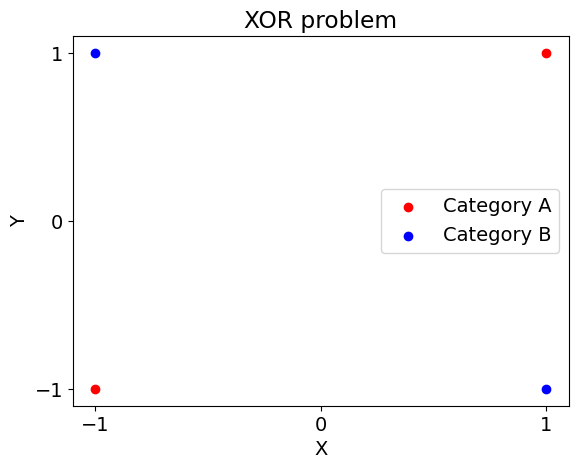

In [51]:
x1 = np.array ([-1., -1., 1., 1.], dtype = np.float32)
x2 = np.array ([-1., 1., -1., 1.], dtype = np.float32)
y  = np.array ([-1., 1., 1., -1.],dtype = np.float32)

plt.scatter(x1[y == -1.], x2[y == -1.], c = 'r', label = 'Category A')
plt.scatter(x1[y == 1.], x2[y == 1.], c = 'b', label = 'Category B')
plt.xlabel('X')
plt.ylabel('Y')
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
plt.legend()
plt.title('XOR problem')

# X, y, _, _ = create_dataset(x1, x2, y, n_repeats=50, noise_lev=0.25)

X = torch.tensor([x1, x2]).T
y = torch.tensor(y).unsqueeze(1)

# plt.savefig("x-or problem.svg")

In [55]:
n_runs = 20
n_epochs = 5000  # Number of epochs
dim_input = 2  # Input dimension = (X, Y)
dim_hidden = 500  # Hidden neurons
dim_output = 1  # Output dimension = Category A or B (0, 1)

lr = 2e-3  # Learning rate
# Initialization scale
w1_inits = [0.001,0.01,0.1,0.5]
# w1_inits = [0.5, 0.5, 0.5 ,0.5]
w2_init = 1/dim_hidden

# wd_lambdas = [0, 0.25, 0.5, 1]

models = []
losses = np.zeros((len(w1_inits), n_runs, n_epochs))
w1_rel_changes = np.zeros((len(w1_inits), n_runs, n_epochs))
w2_rel_changes = np.zeros((len(w1_inits), n_runs, n_epochs))

# Training
for w_i, w1_init in enumerate(w1_inits):
  for r_i in range(n_runs):
    # Model instantiation
    dlnn_model = LNNet(dim_input, dim_hidden, dim_output, w1_init, w2_init)
    # Weights re-initialization
    # initializer_(dlnn_model, [w1_init, w2_init])
    
    # loss_per_run, weight_rel_changes_per_run = train(dlnn_model, X, y, n_epochs=n_epochs, lr=lr, wd_lambda=wd_lambdas[w_i])
    loss_per_run, weight_rel_changes_per_run = train(dlnn_model, X, y, n_epochs=n_epochs, lr=lr)
    losses[w_i, r_i, :] = loss_per_run
    w1_rel_changes[w_i, r_i, :] = weight_rel_changes_per_run[0]
    w2_rel_changes[w_i, r_i, :] = weight_rel_changes_per_run[1]

  models.append(dlnn_model)

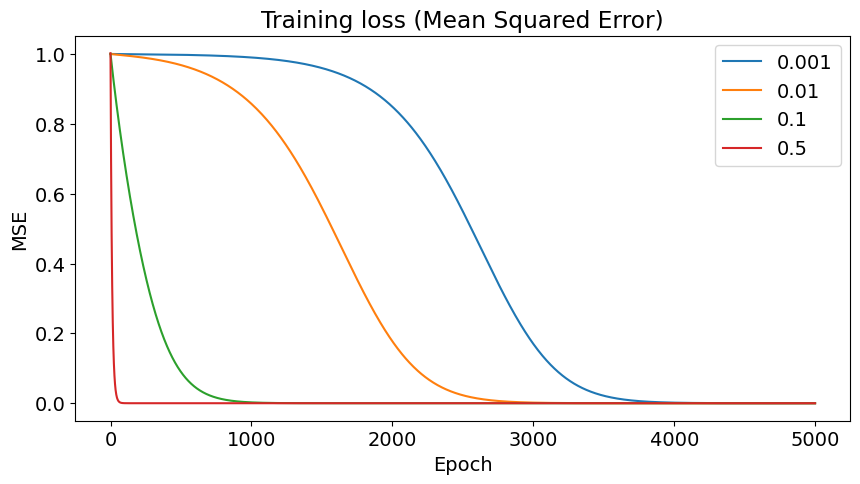

In [56]:
plot_vt(losses, w1_inits)

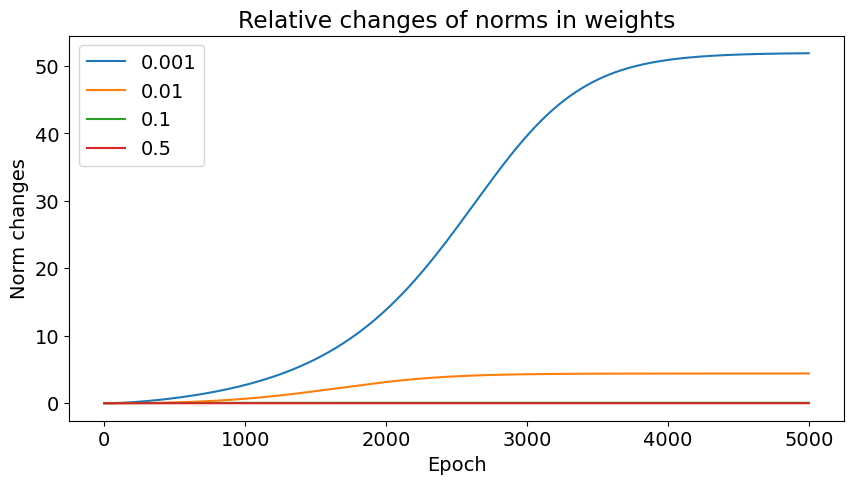

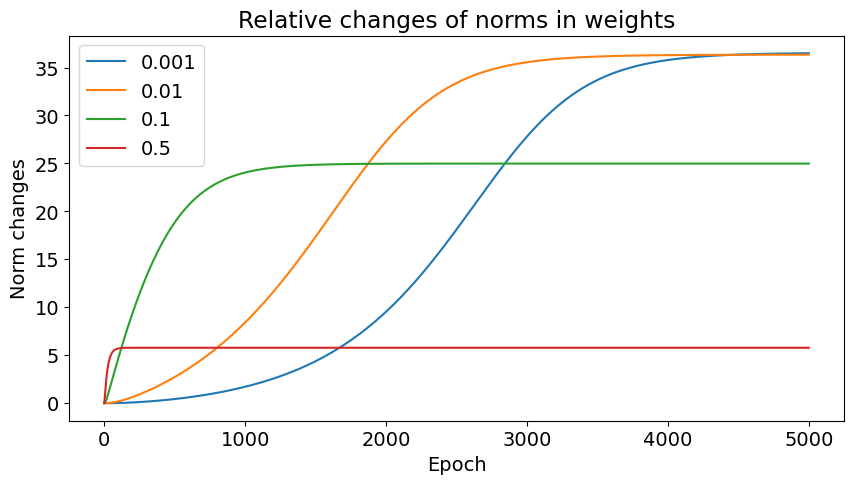

In [57]:
# Plotting relative changes of norms in wieghts
plot_vt(w1_rel_changes, w1_inits, y_label="Norm changes", title="Relative changes of norms in weights")
plot_vt(w2_rel_changes, w1_inits, y_label="Norm changes", title="Relative changes of norms in weights")

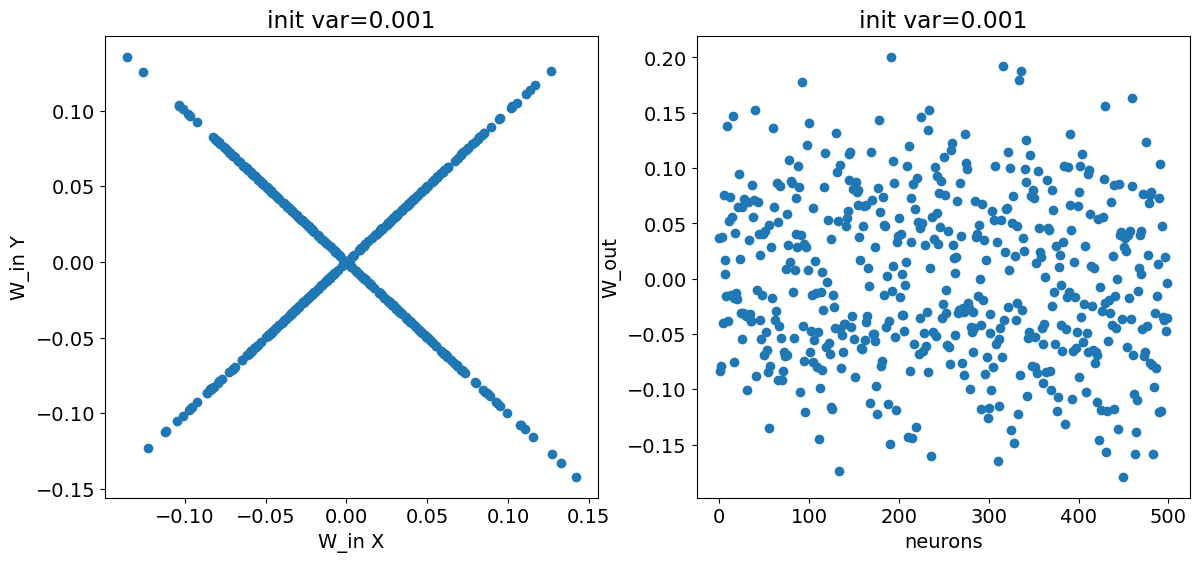

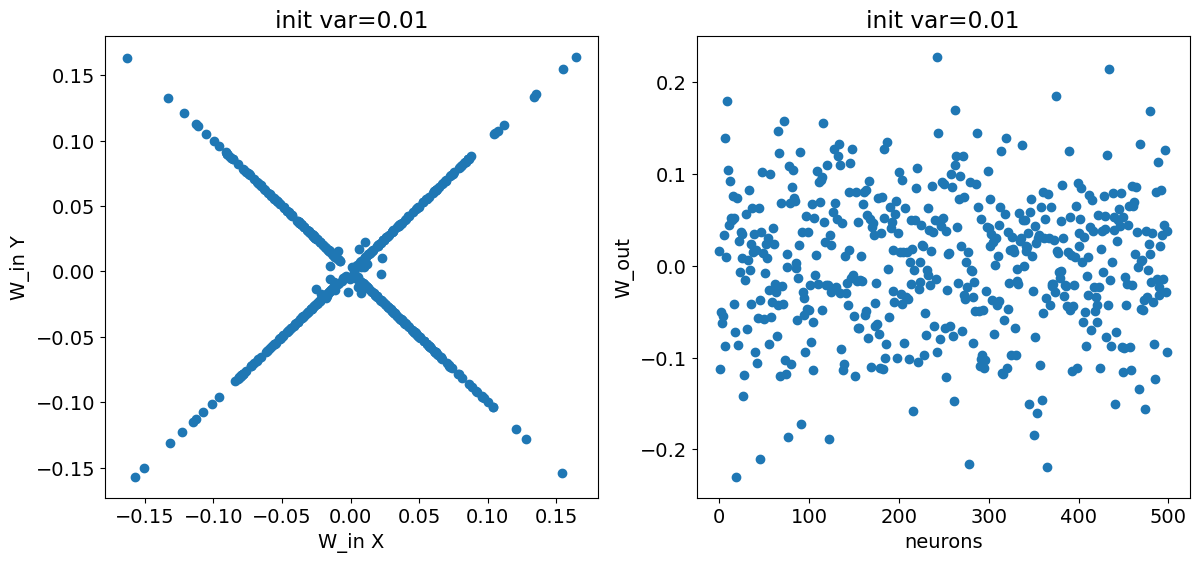

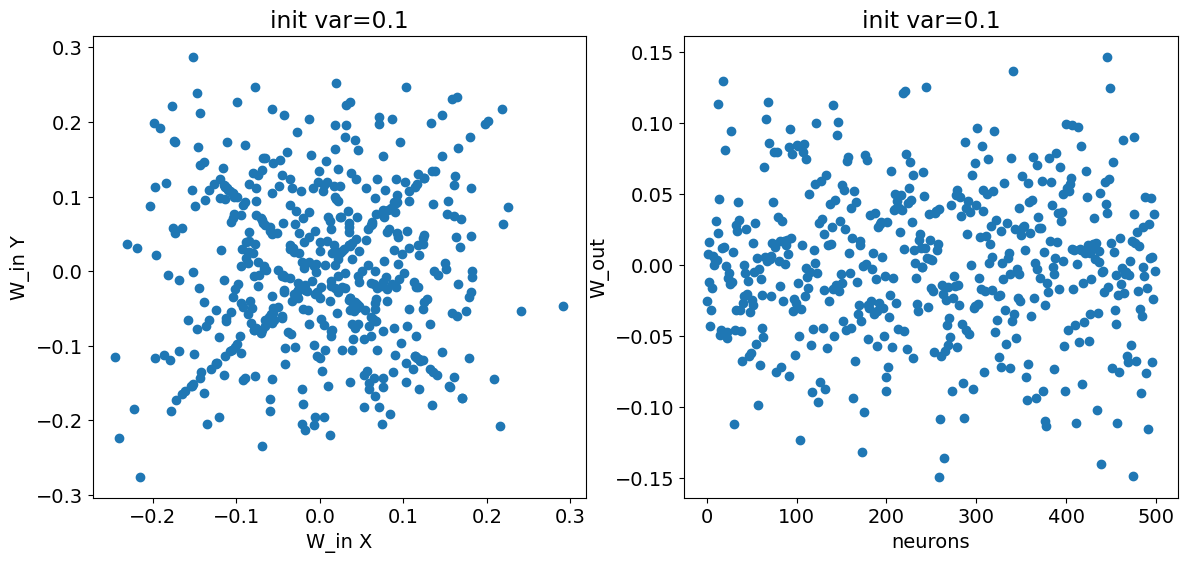

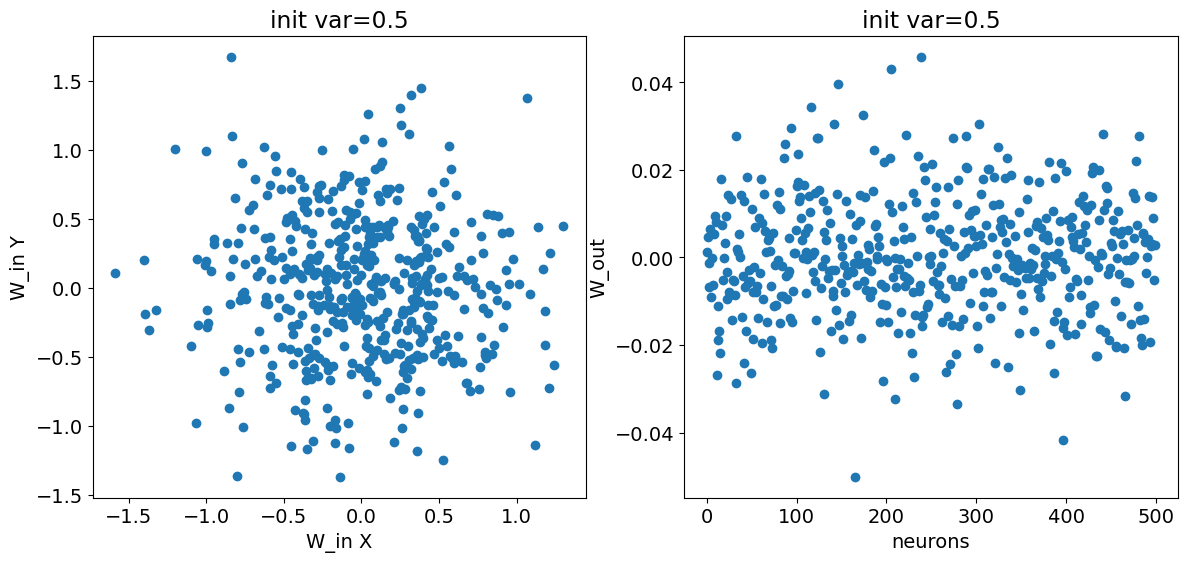

In [58]:
rich_lazy_models = [models[0], models[-1]]
model_titles = ['rich', 'lazy']

for w_i, weight in enumerate(w1_inits):
  # model = rich_lazy_models[a_i]
    model = models[w_i]
    
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(14, 6)

    for p_i, (name, param) in enumerate(model.named_parameters()):
        axis = axes[p_i]
        
        if name == 'in_hid.weight':
            in_hid = param.detach().numpy()
            axis.scatter(in_hid[:, 0], in_hid[:, 1])

            axis.set_xlabel('W_in X')
            axis.set_ylabel('W_in Y')
            # axis.set_xlim(-0.05, 0.05)
            # axis.set_ylim(-0.05, 0.05)

            axis.set_title(f'init var={weight}')

        elif name == 'hid_out.weight':
            hid_out = param.detach().numpy()
            axis.scatter(np.arange(hid_out.shape[1]), hid_out[0])

            axis.set_xlabel('neurons')
            axis.set_ylabel('W_out')
            # axis.set_ylim(-0.05, 0.05)

            axis.set_title(f'init var={weight}')

# plt.savefig("rich_lazy_learning_trained.svg")

In [91]:
import glob, os
for f in glob.glob("task_rep_*.png"):
    os.remove(f)

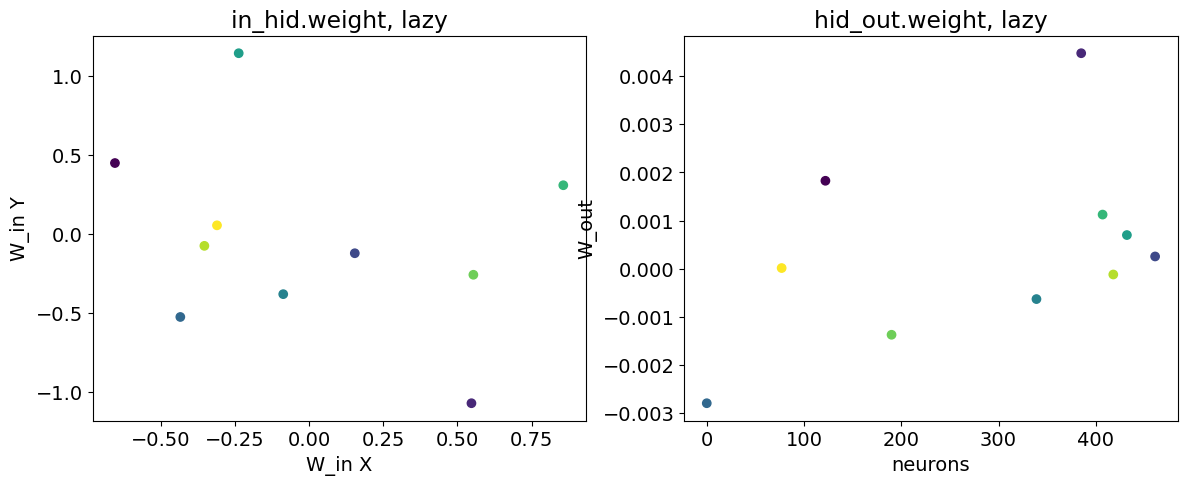

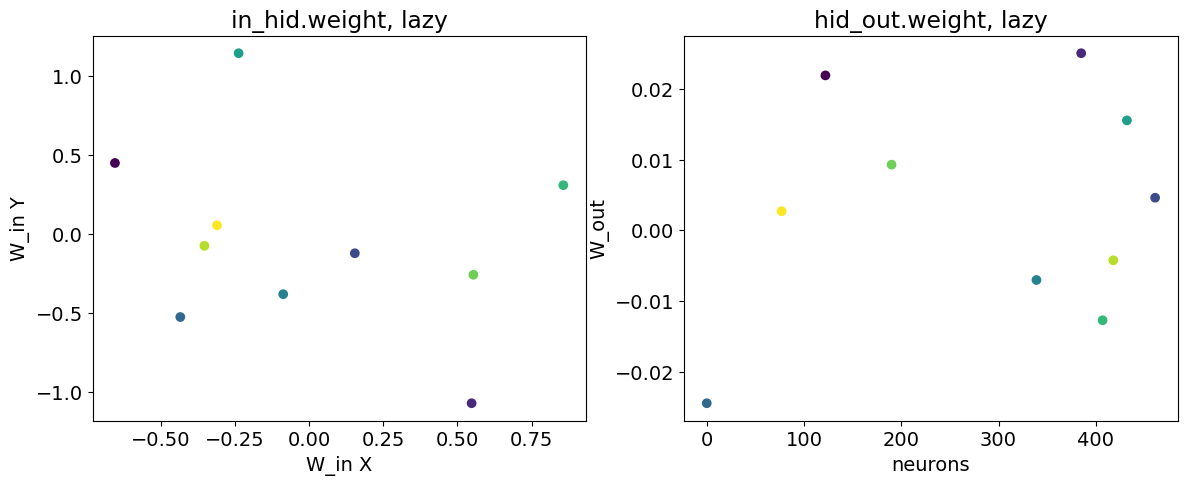

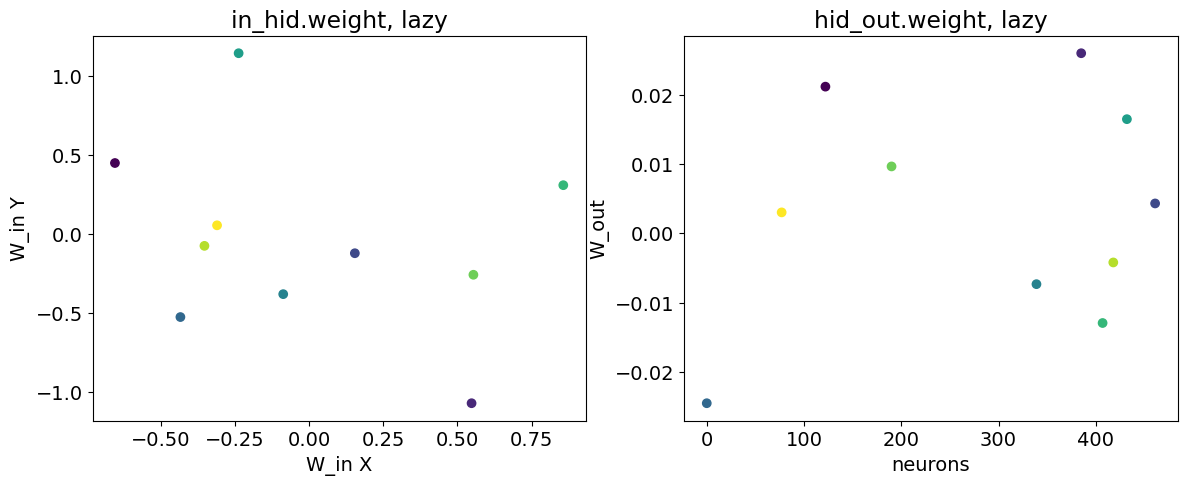

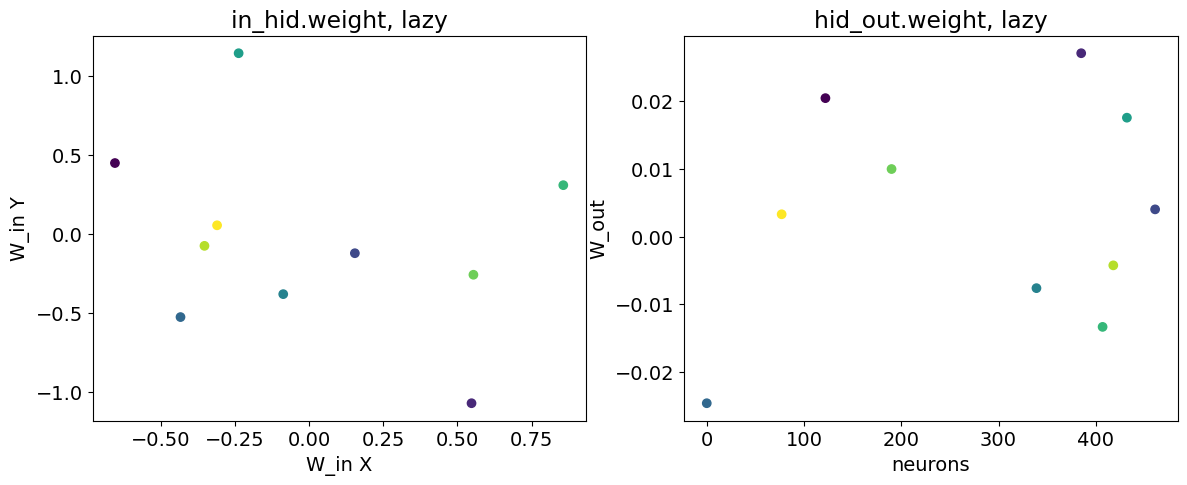

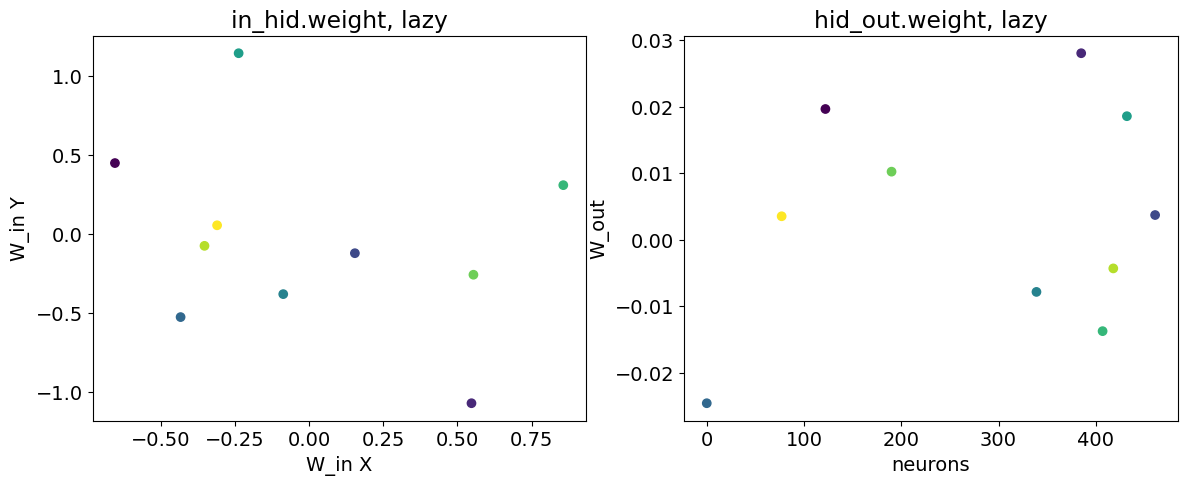

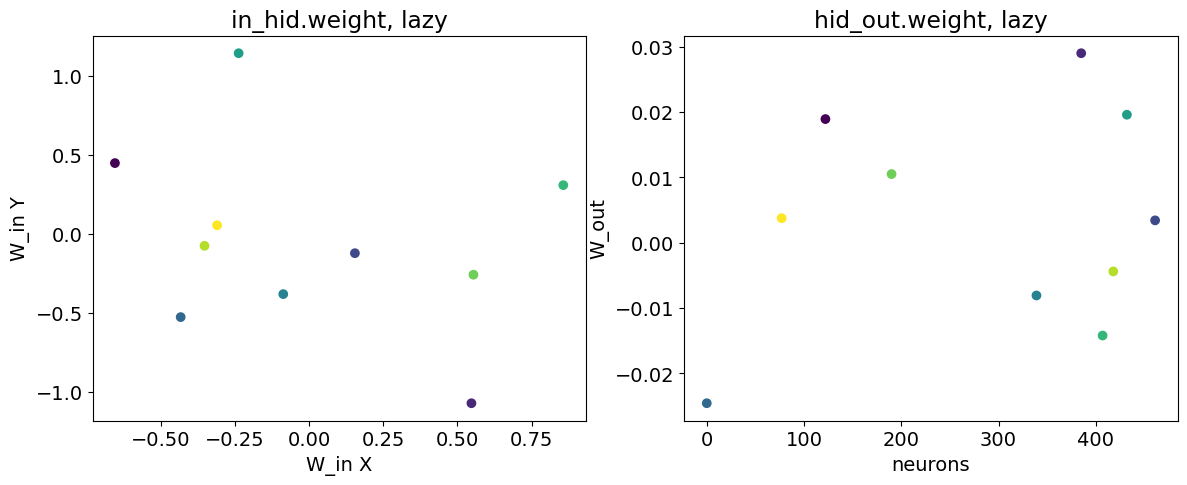

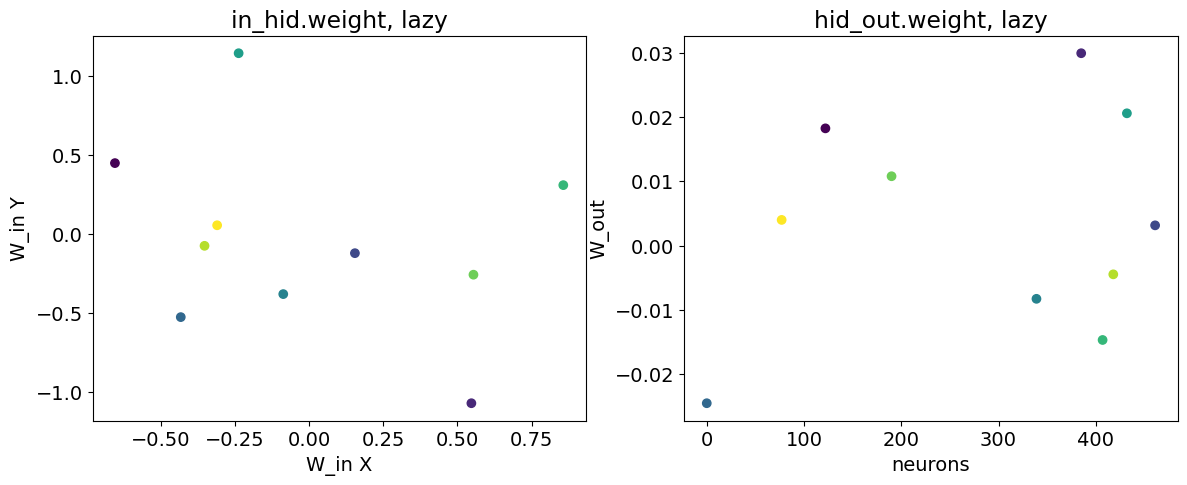

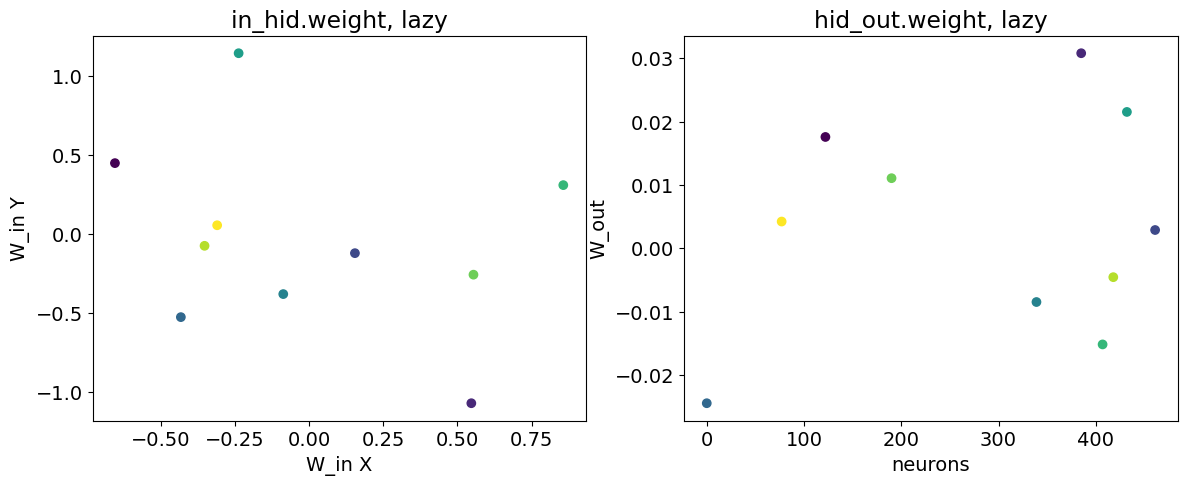

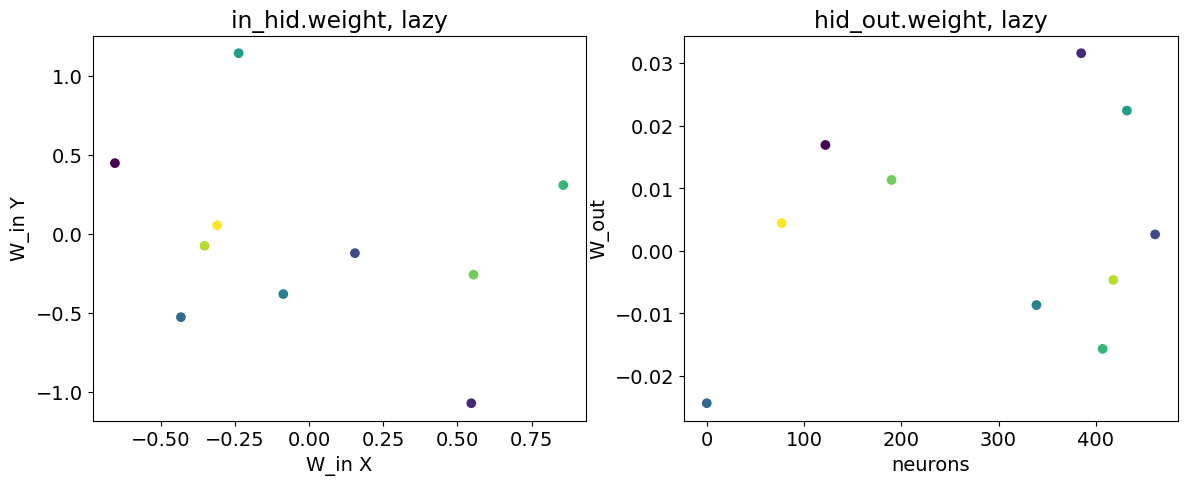

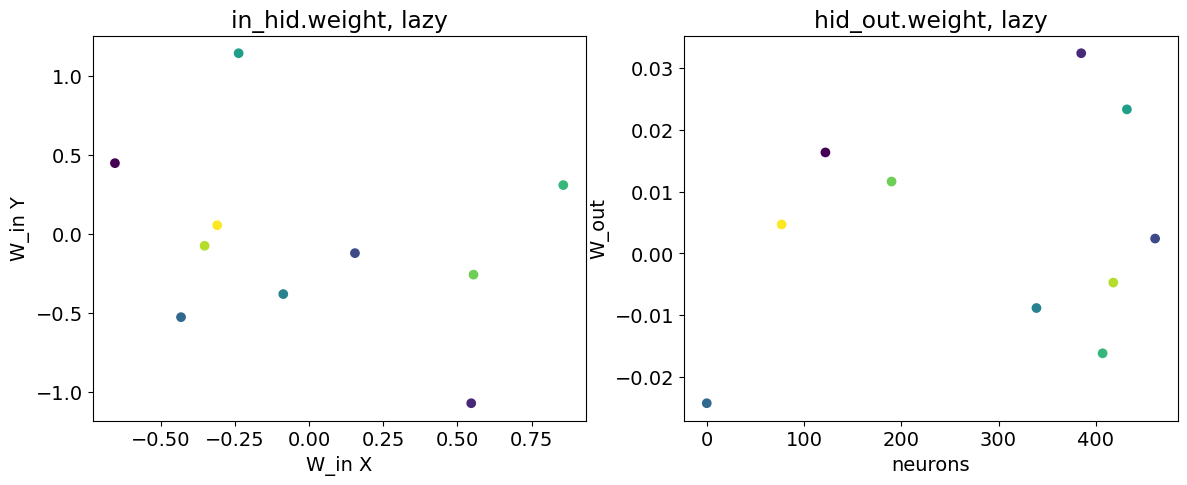

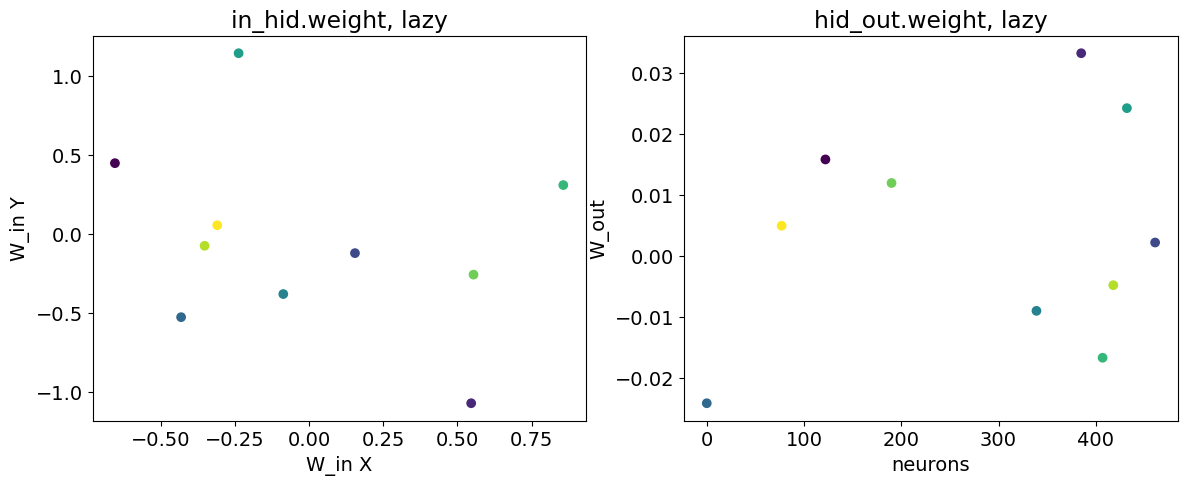

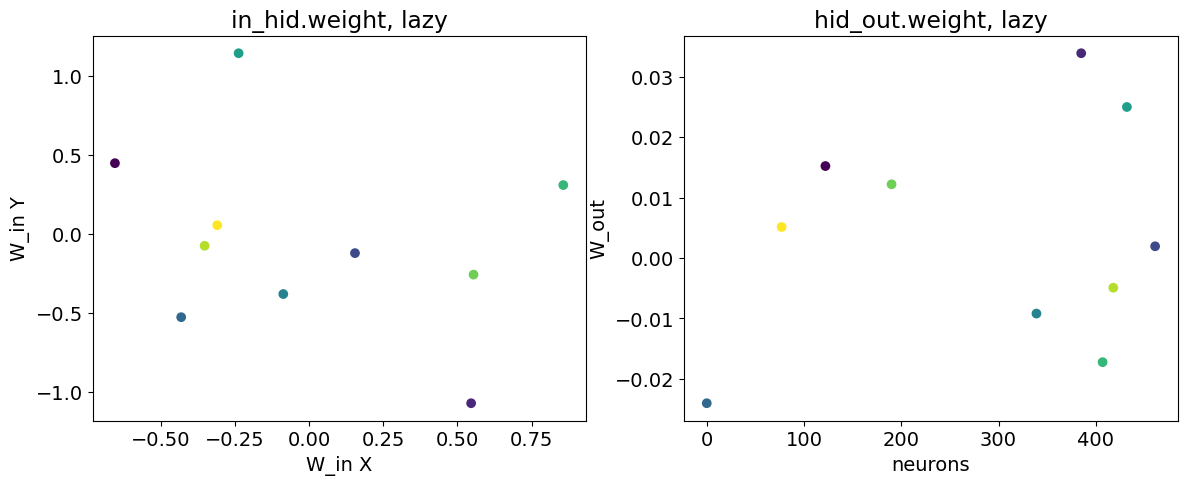

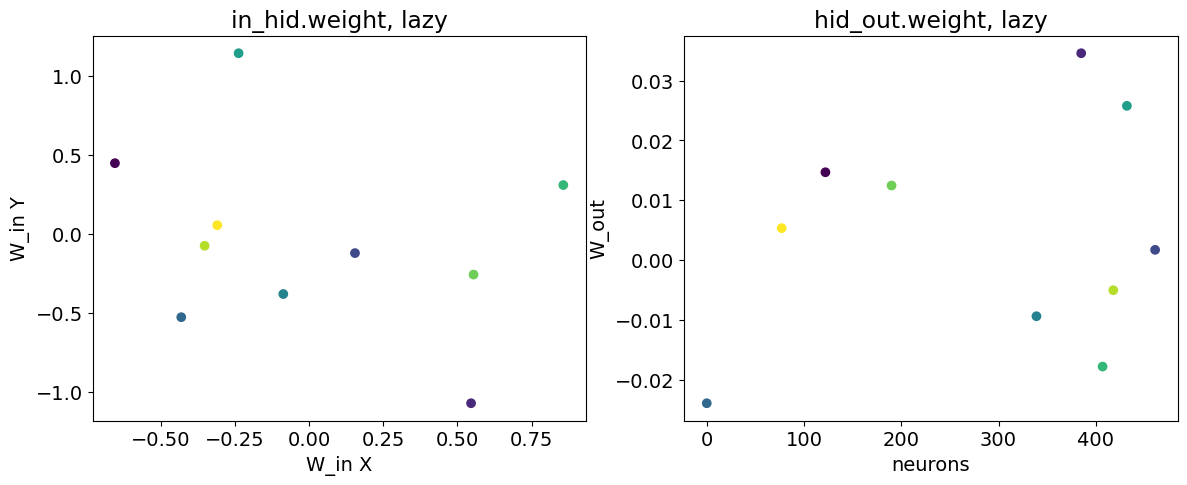

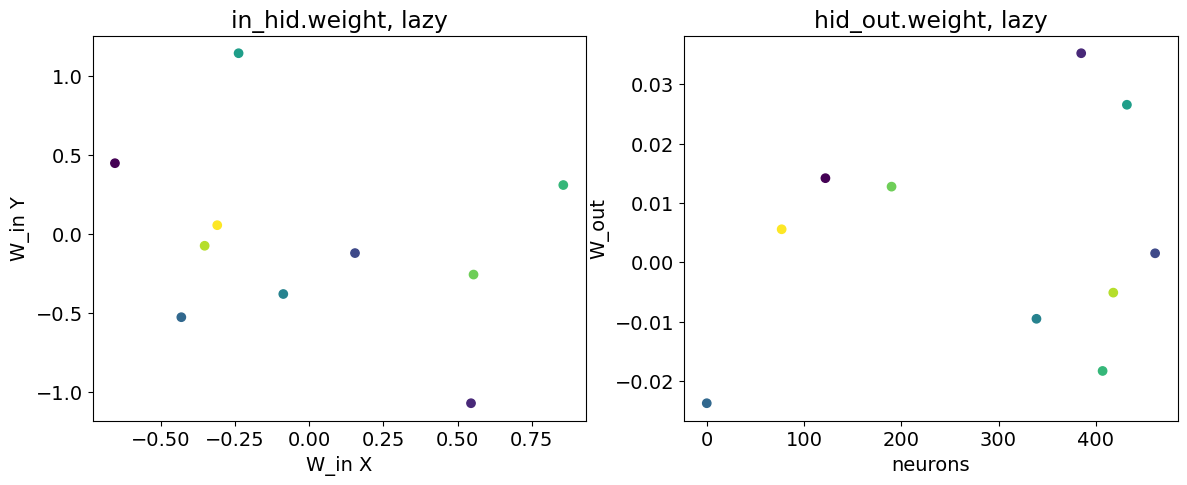

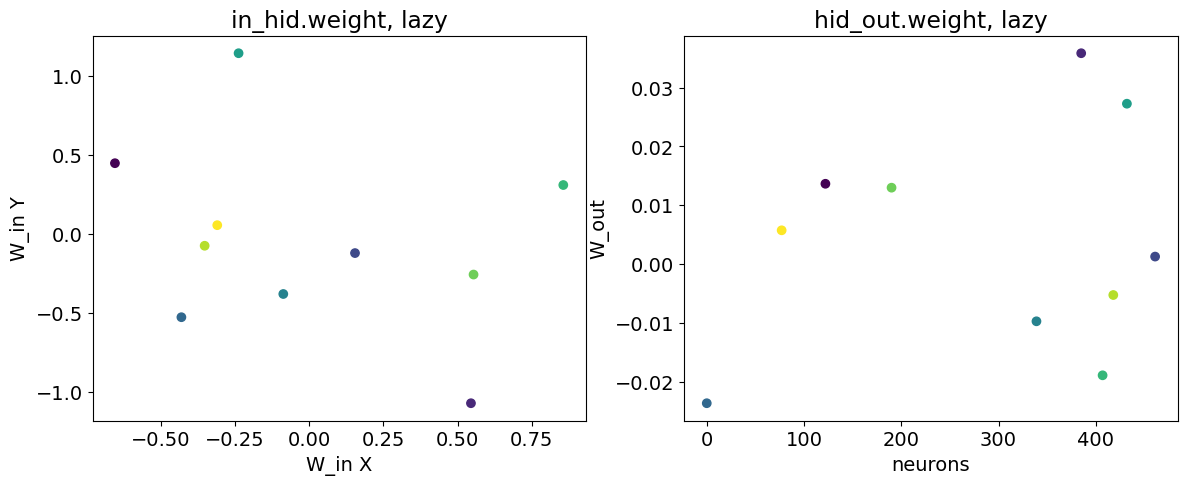

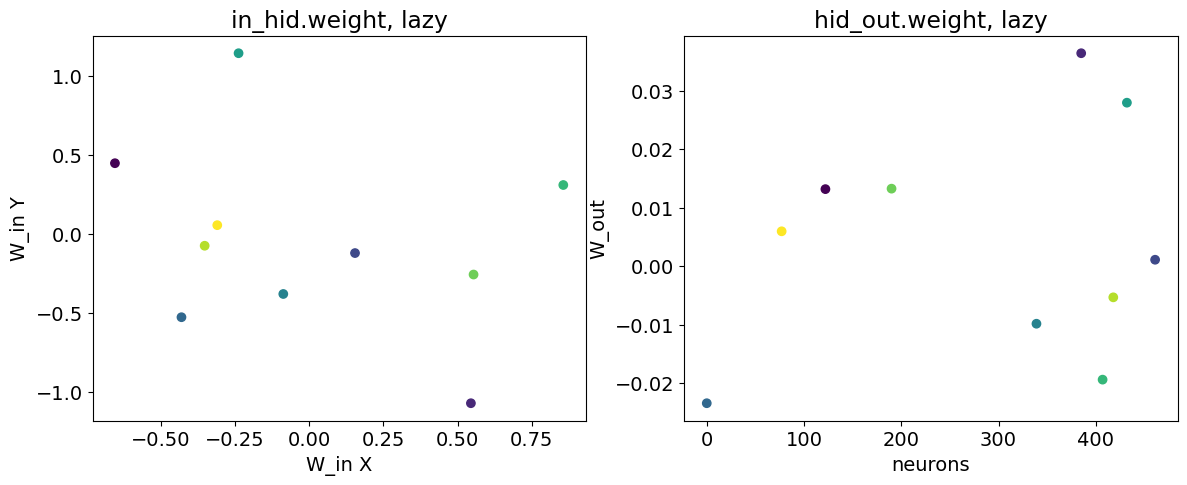

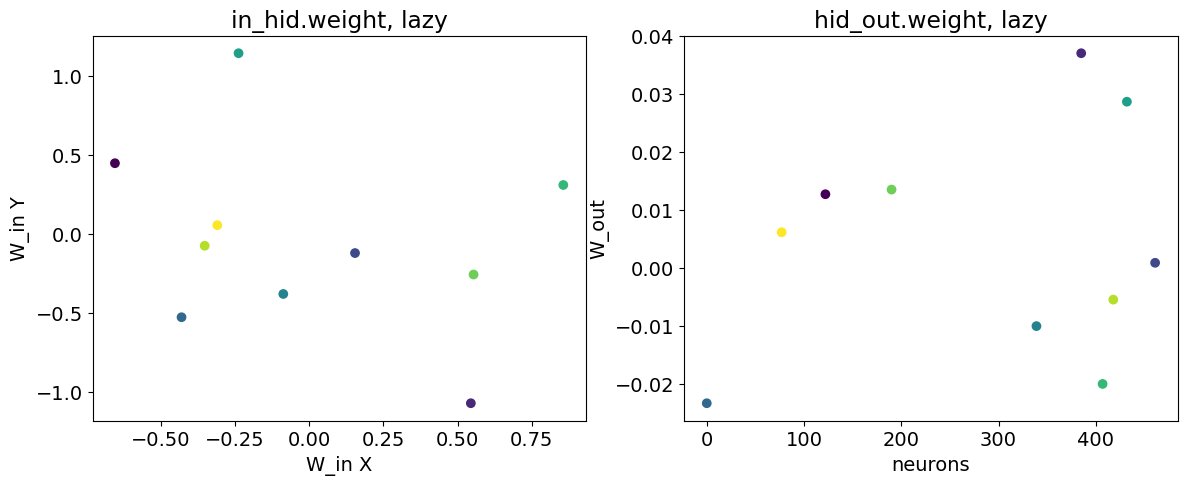

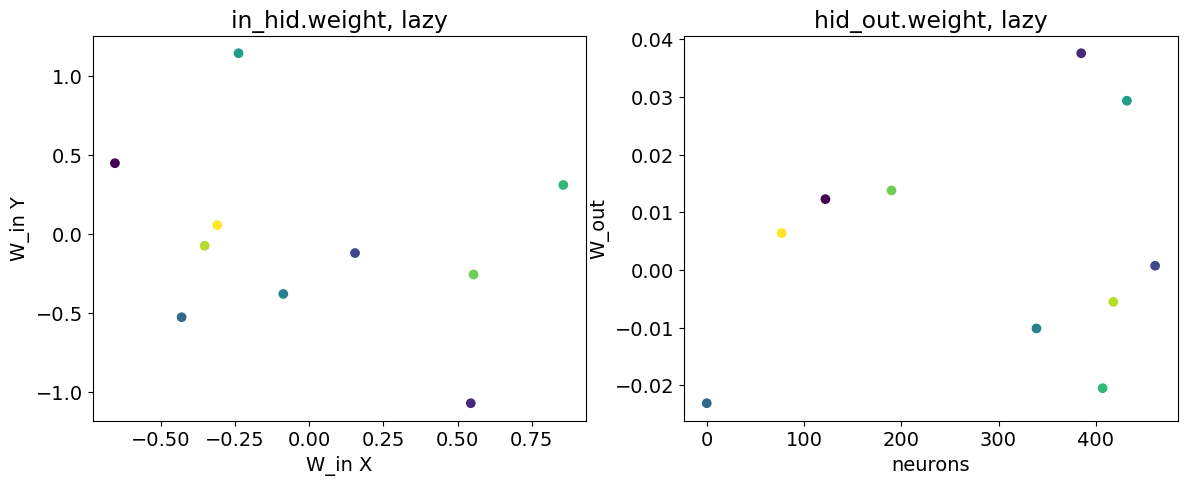

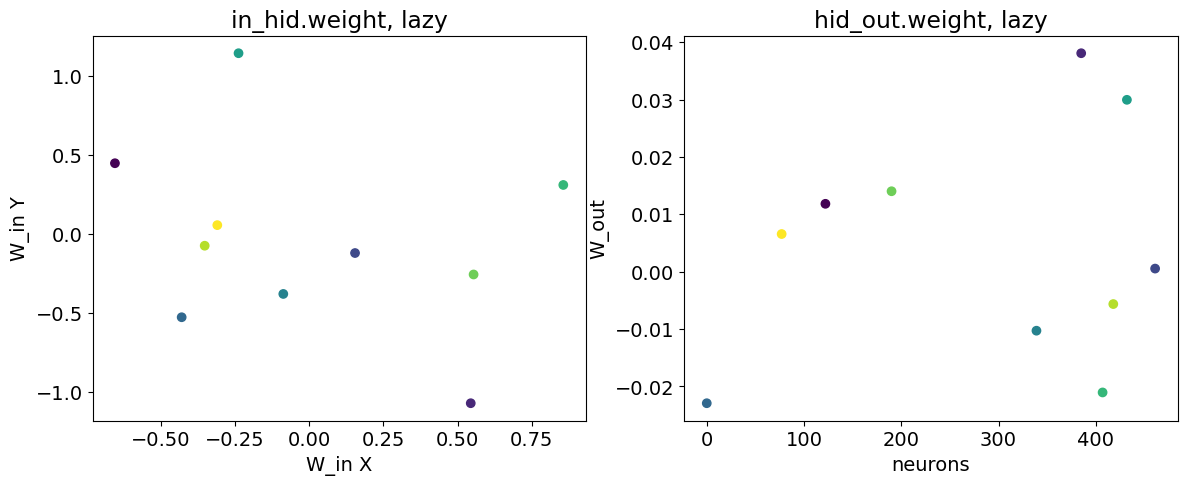

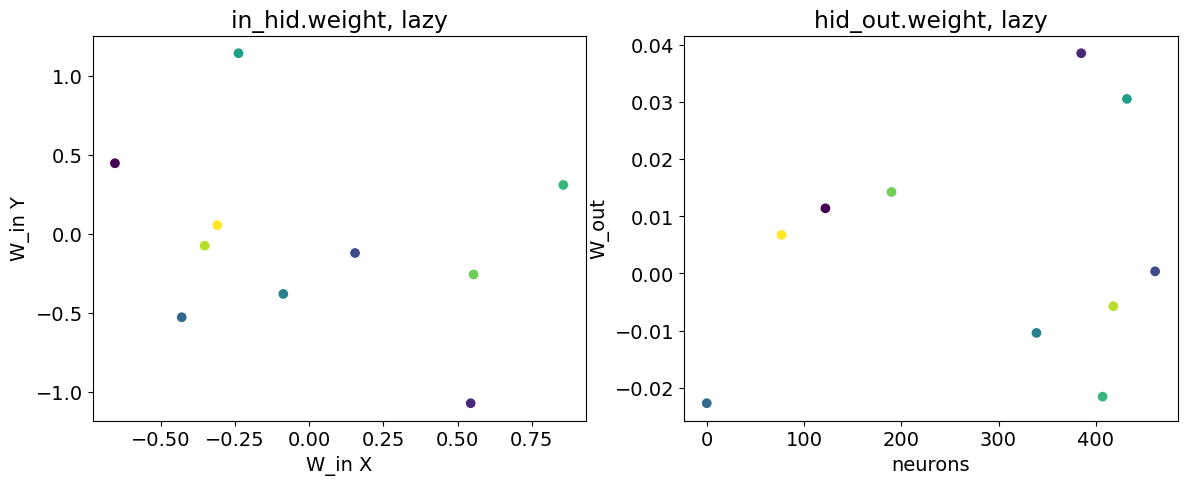

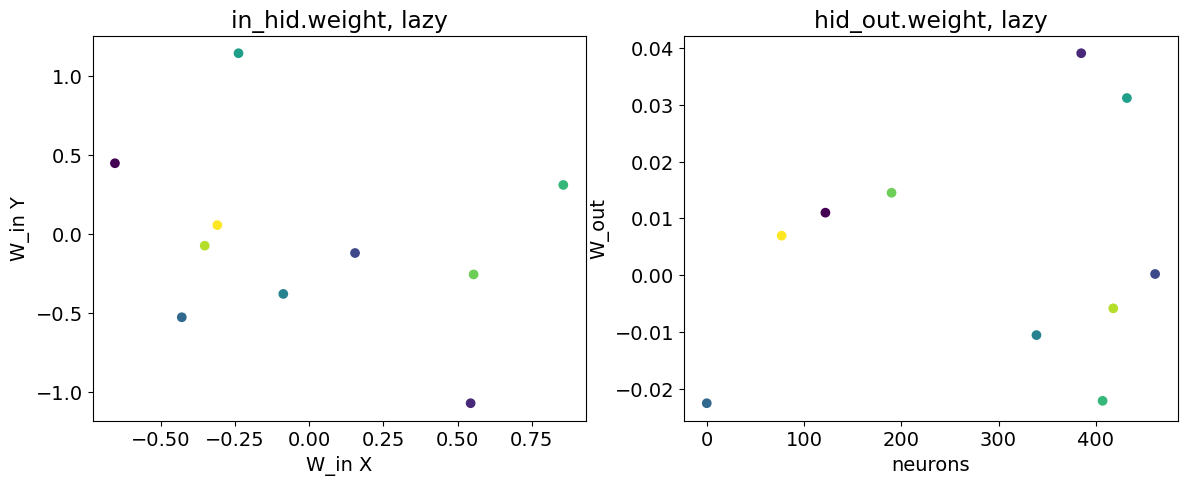

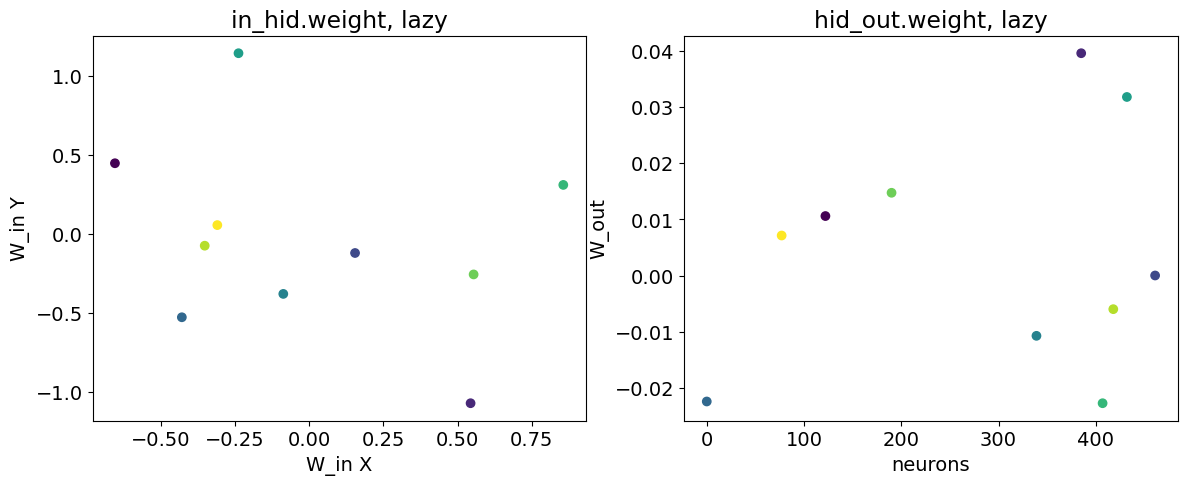

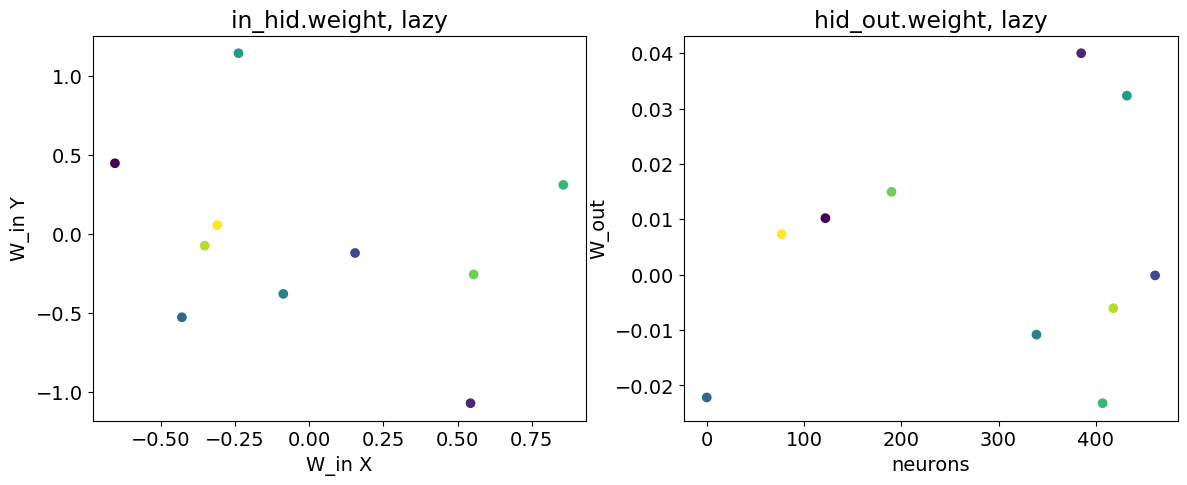

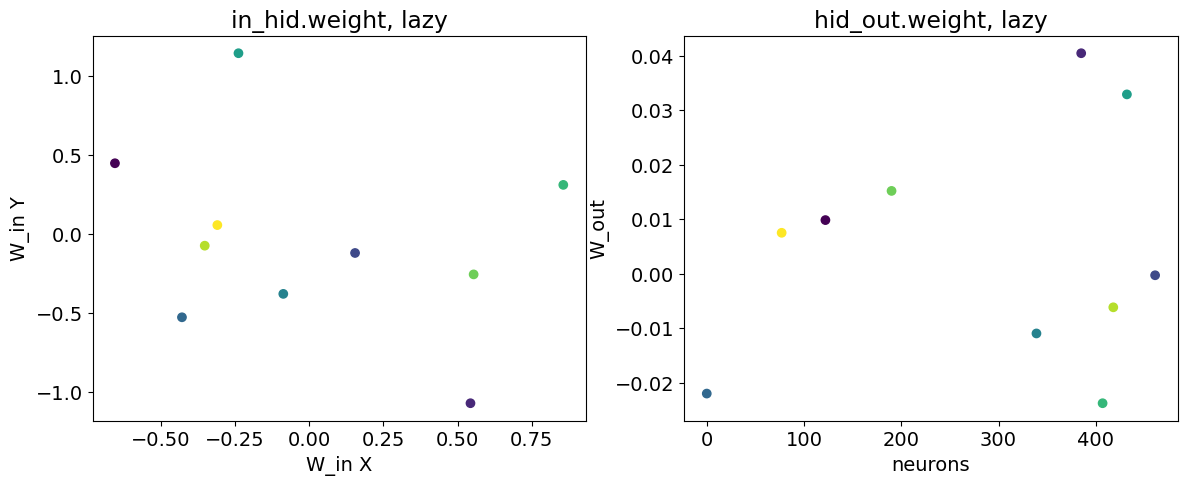

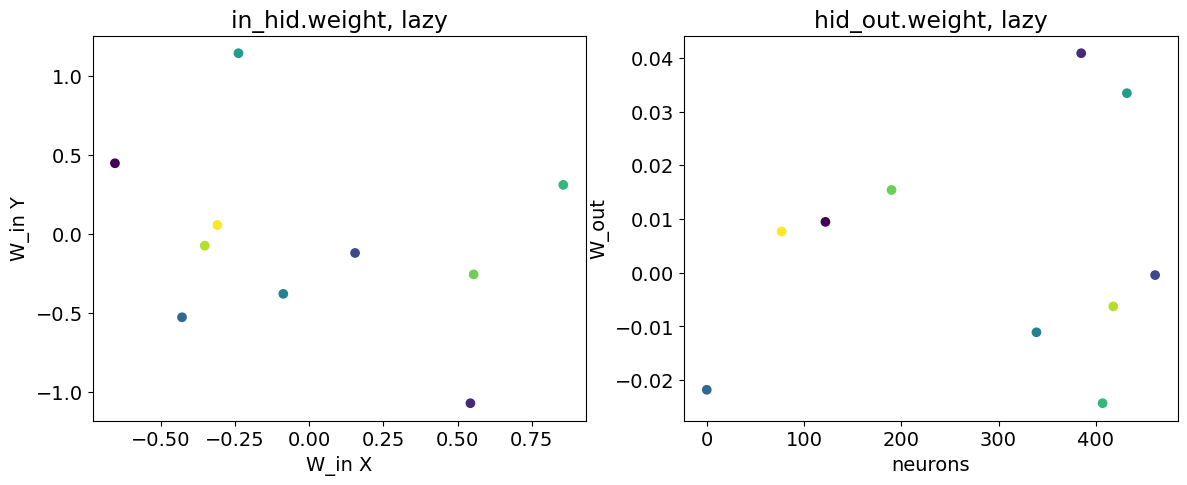

In [48]:
n_epochs = 5000  # Number of epochs
dim_input = 2  # Input dimension = (X, Y)
dim_hidden = 500  # Hidden neurons
dim_output = 1  # Output dimension = Category A or B (0, 1)

lr = 2e-3  # Learning rate
# Initialization scale
# w1_inits = [0.001,0.01,0.1,0.5]
w1_init = 0.5
w2_init = 1/dim_hidden

# Training
dlnn_model = LNNet(dim_input, dim_hidden, dim_output, w1_init, w2_init)

optimizer = optim.SGD(dlnn_model.parameters(), lr=lr)
criterion = nn.MSELoss()

vis_num_hidden = 10
sub_sample_idx = np.random.choice(dim_hidden, size=vis_num_hidden, replace=False)
vis_hidden_color = np.linspace(0, 1, vis_num_hidden)

for i in range(n_epochs):
    optimizer.zero_grad()
    y_pred, hiddens = dlnn_model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    
    if i % 200 == 0:
        fig, axes = plt.subplots(1, 2)
        fig.set_size_inches(14, 5)
        for p_i, (name, param) in enumerate(dlnn_model.named_parameters()):
            axis = axes[p_i]
            
            if name == 'in_hid.weight':
                in_hid = param.detach().numpy()
                # axis.scatter(in_hid[:, 0], in_hid[:, 1])
                axis.scatter(in_hid[sub_sample_idx, 0], in_hid[sub_sample_idx, 1], c=vis_hidden_color)
                # axis.set_xticks([])
                # axis.set_yticks([])

                axis.set_xlabel('W_in X')
                axis.set_ylabel('W_in Y')
                # axis.set_xlim(-2, 2)
                # axis.set_ylim(-2, 2)
                
                axis.set_title(f'{name}, lazy')
                
            elif name == 'hid_out.weight':
                hid_out = param.detach().numpy()
                # axis.scatter(np.arange(hid_out.shape[1]), hid_out[0])
                axis.scatter(sub_sample_idx, hid_out[0, sub_sample_idx], c=vis_hidden_color)
                
                axis.set_xlabel('neurons')
                axis.set_ylabel('W_out')
                # axis.set_ylim(-0.05, 0.05)
                
                axis.set_title(f'{name}, lazy')
        
        plt.show()
        # plt.savefig(f'lazy_{i:04d}.png')
        # plt.cla()
        # plt.close()

In [90]:
n_epochs = 5000  # Number of epochs
dim_input = 2  # Input dimension = (X, Y)
dim_hidden = 500  # Hidden neurons
dim_output = 1  # Output dimension = Category A or B (0, 1)

lr = 2e-3  # Learning rate
# Initialization scale
# w1_inits = [0.001,0.01,0.1,0.5]
w1_inits = [0.001, 0.25]
w2_init = 1/dim_hidden

# Training

models = [LNNet(dim_input, dim_hidden, dim_output, w1_init, w2_init) for w1_init in w1_inits]
optimizers = [optim.SGD(model.parameters(), lr=lr) for model in models ]
criterions = [nn.MSELoss() for model in models ]

model_titles = ['rich', 'lazy']

for i in range(n_epochs):
    optimizers[m_i].zero_grad()
    for m_i, model in enumerate(models):
        optimizers[m_i].zero_grad()
        y_pred, hiddens = model(X)
        loss = criterions[m_i](y_pred, y)
        loss.backward()
        optimizers[m_i].step()
    
    if i % 200 == 0:
        fig, axes = plt.subplots(2, 2)
        fig.set_size_inches(16, 14)
        for m_i, model in enumerate(models):
            for p_i, (name, param) in enumerate(model.named_parameters()):
                axis = axes[m_i, p_i]
                if name == 'in_hid.weight':
                    in_hid = param.detach().numpy()
                    axis.scatter(in_hid[:, 0], in_hid[:, 1])

                    axis.set_xlabel('W_in X')
                    axis.set_ylabel('W_in Y')
                    axis.set_xlim(-0.5, 0.5)
                    axis.set_ylim(-0.5, 0.5)

                    axis.set_title(f'in->hid, {model_titles[m_i]}')

                elif name == 'hid_out.weight':
                    hid_out = param.detach().numpy()
                    axis.scatter(np.arange(hid_out.shape[1]), hid_out[0])

                    axis.set_xlabel('neurons')
                    axis.set_ylabel('W_out')
                    axis.set_ylim(-0.2, 0.2)

                    axis.set_title(f'hid->out, {model_titles[m_i]}')

        # plt.show()
        plt.savefig(f'task_rep_{i:04d}.png')
        plt.cla()
        plt.close()

## Rich-learning via L2-regularization

In [134]:
n_runs = 20
n_epochs = 5000  # Number of epochs
dim_input = 2  # Input dimension = (X, Y)
dim_hidden = 500  # Hidden neurons
dim_output = 1  # Output dimension = Category A or B (0, 1)

lr = 2e-3  # Learning rate
# Initialization scale
# w1_inits = [0.001,0.01,0.1,0.5]
w1_init = 0.1
w2_init = 1/dim_hidden

# wd_lambdas = [0, 0.25, 0.5, 1]
wd_lambdas = [0, 0.125, 0.25, 0.5]

models = []
losses = np.zeros((len(wd_lambdas), n_runs, n_epochs))
w1_rel_changes = np.zeros((len(wd_lambdas), n_runs, n_epochs))
w2_rel_changes = np.zeros((len(wd_lambdas), n_runs, n_epochs))

# Training
for w_i, wd_lambda in enumerate(wd_lambdas):
  for r_i in range(n_runs):
    # Model instantiation
    dlnn_model = LNNet(dim_input, dim_hidden, dim_output, w1_init, w2_init)
    
    loss_per_run, weight_rel_changes_per_run = train(dlnn_model, X, y, n_epochs=n_epochs, lr=lr, wd_lambda=wd_lambda)
    losses[w_i, r_i, :] = loss_per_run
    w1_rel_changes[w_i, r_i, :] = weight_rel_changes_per_run[0]
    w2_rel_changes[w_i, r_i, :] = weight_rel_changes_per_run[1]

  models.append(dlnn_model)

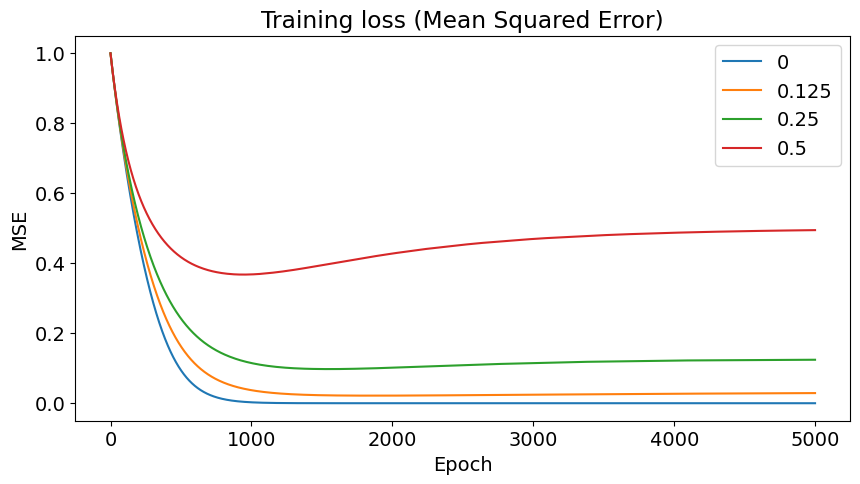

In [135]:
plot_vt(losses, wd_lambdas)

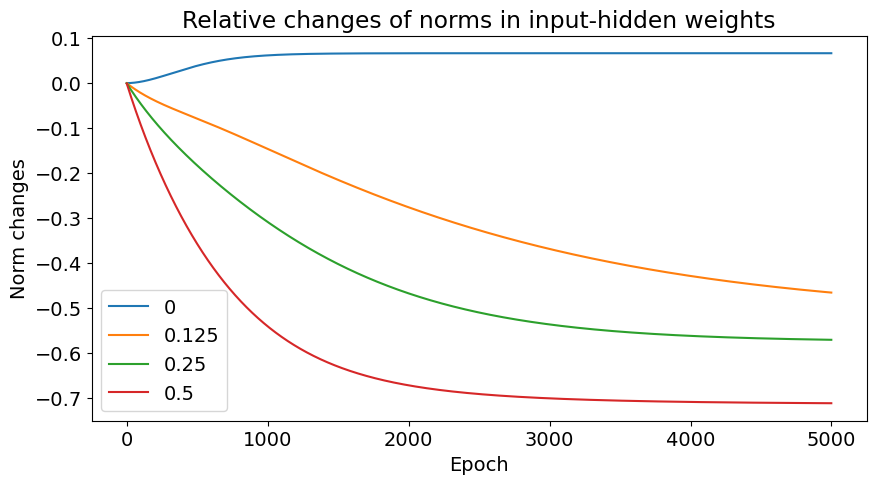

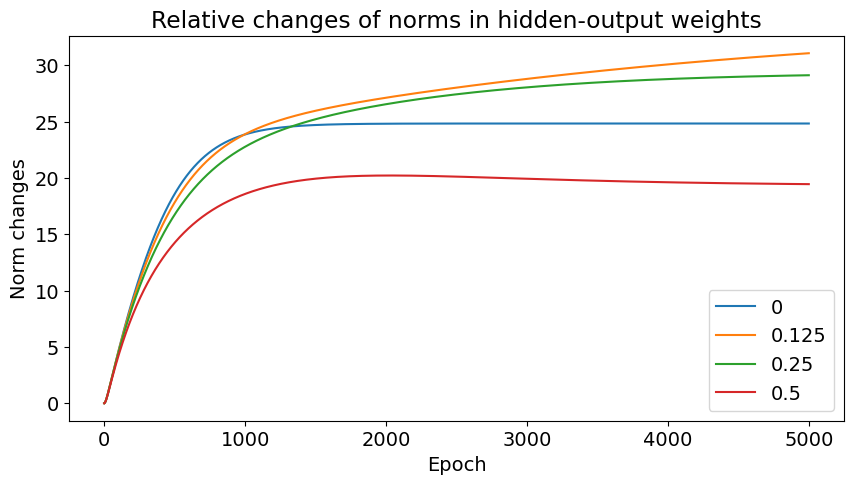

In [136]:
# Plotting relative changes of norms in wieghts
plot_vt(w1_rel_changes, wd_lambdas, y_label="Norm changes", title="Relative changes of norms in input-hidden weights")
plot_vt(w2_rel_changes, wd_lambdas, y_label="Norm changes", title="Relative changes of norms in hidden-output weights")

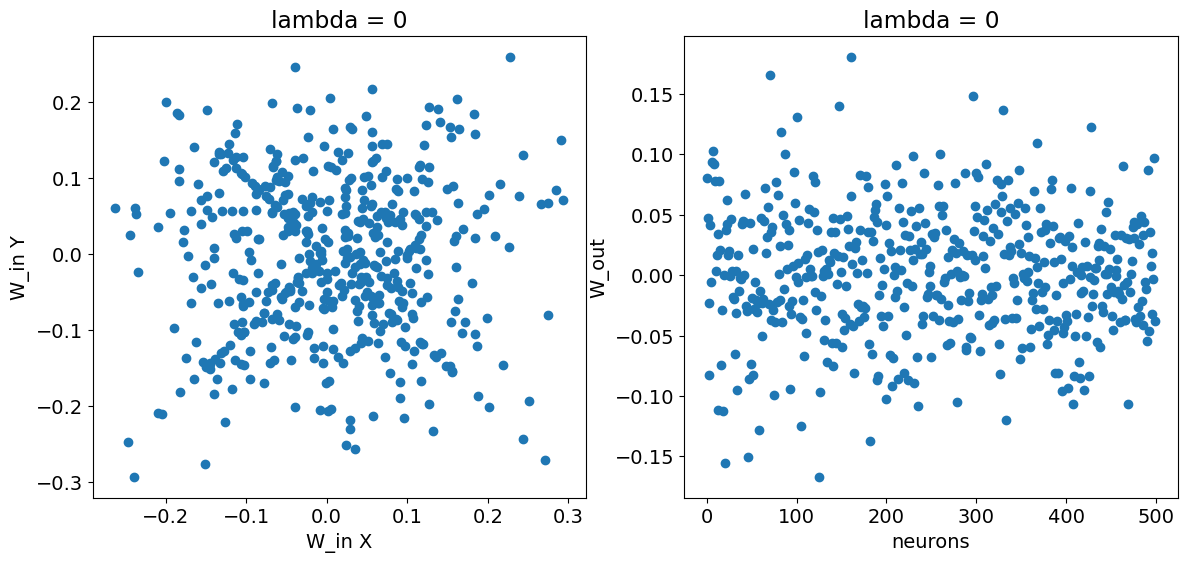

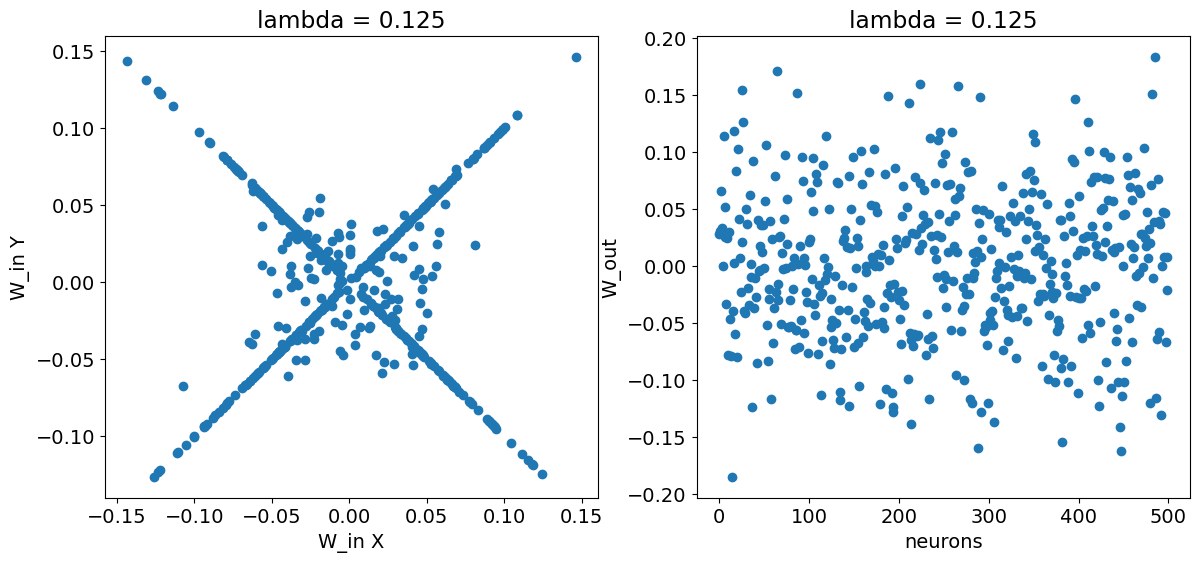

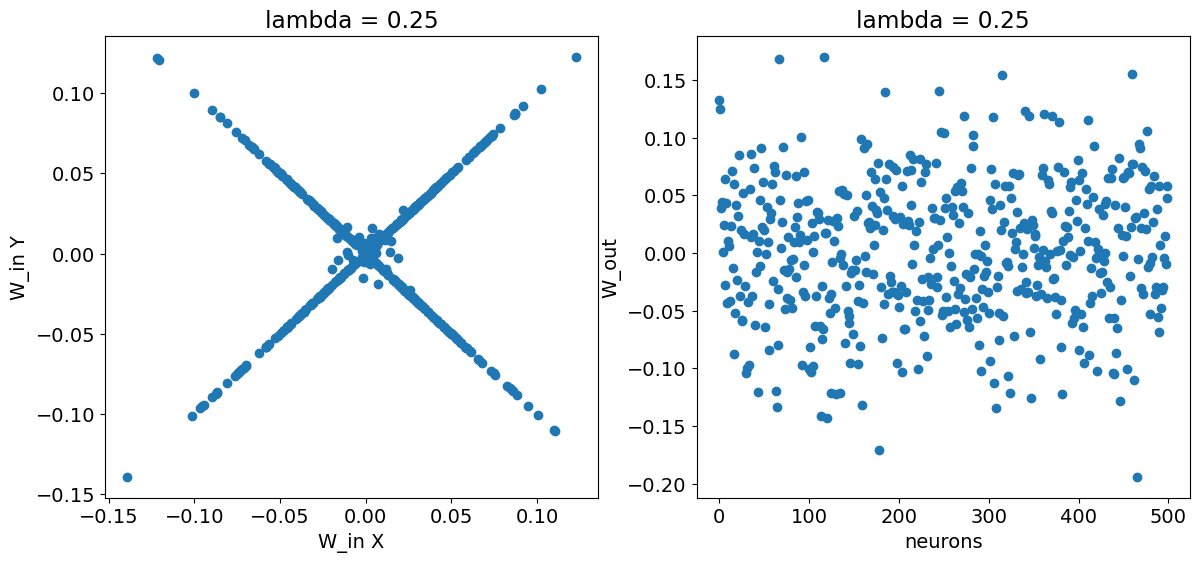

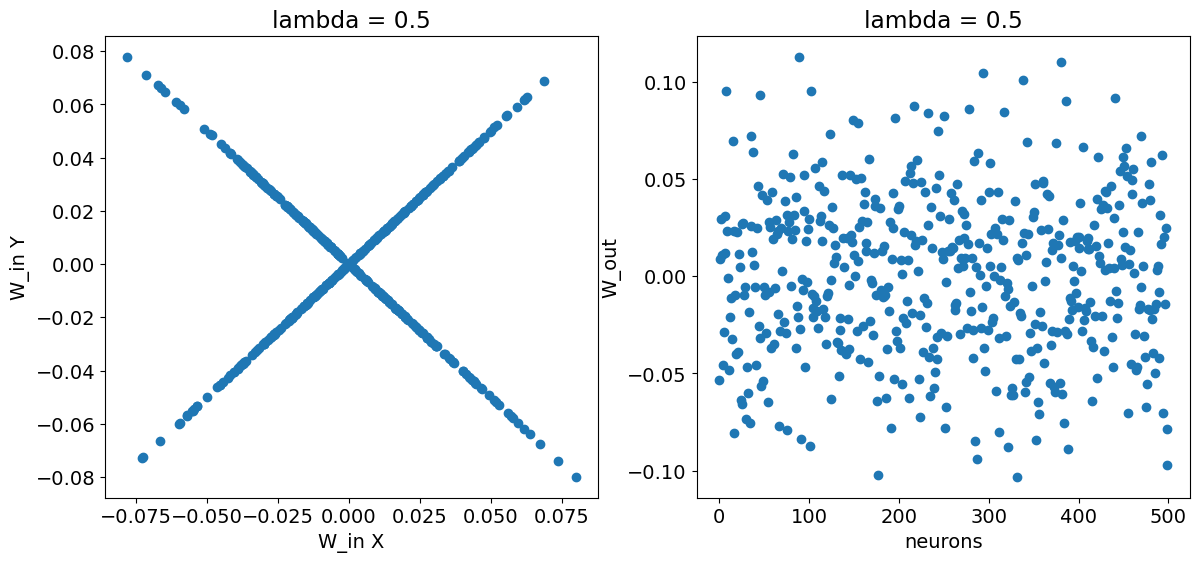

In [137]:
for w_i, weight in enumerate(wd_lambdas):
  # model = rich_lazy_models[a_i]
    model = models[w_i]
    
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(14, 6)

    for p_i, (name, param) in enumerate(model.named_parameters()):
        axis = axes[p_i]
        
        if name == 'in_hid.weight':
            in_hid = param.detach().numpy()
            axis.scatter(in_hid[:, 0], in_hid[:, 1])

            axis.set_xlabel('W_in X')
            axis.set_ylabel('W_in Y')
            # axis.set_xlim(-0.05, 0.05)
            # axis.set_ylim(-0.05, 0.05)

            axis.set_title(f'lambda = {weight}')

        elif name == 'hid_out.weight':
            hid_out = param.detach().numpy()
            axis.scatter(np.arange(hid_out.shape[1]), hid_out[0])

            axis.set_xlabel('neurons')
            axis.set_ylabel('W_out')
            # axis.set_ylim(-0.05, 0.05)

            axis.set_title(f'lambda = {weight}')

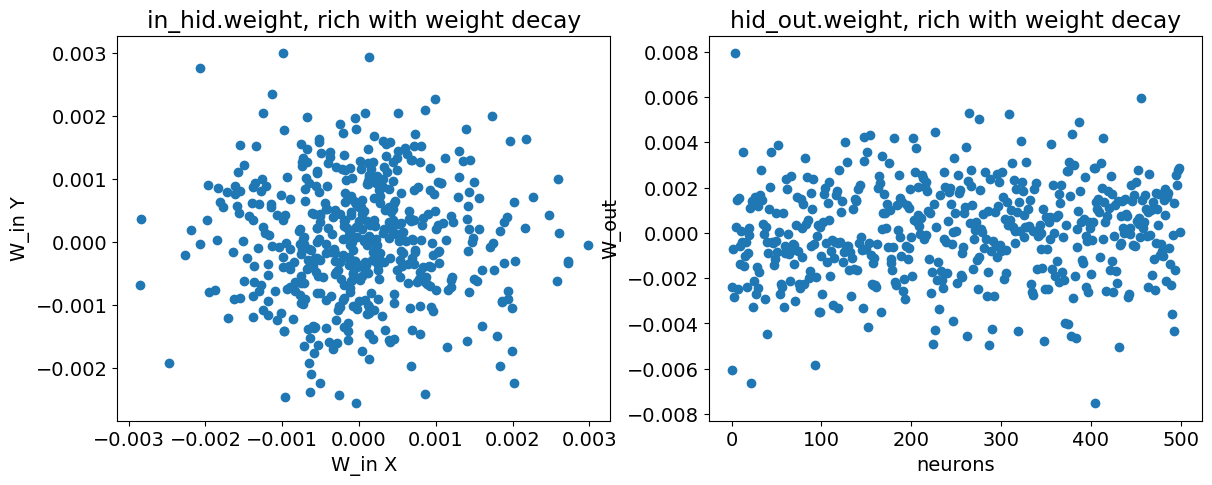

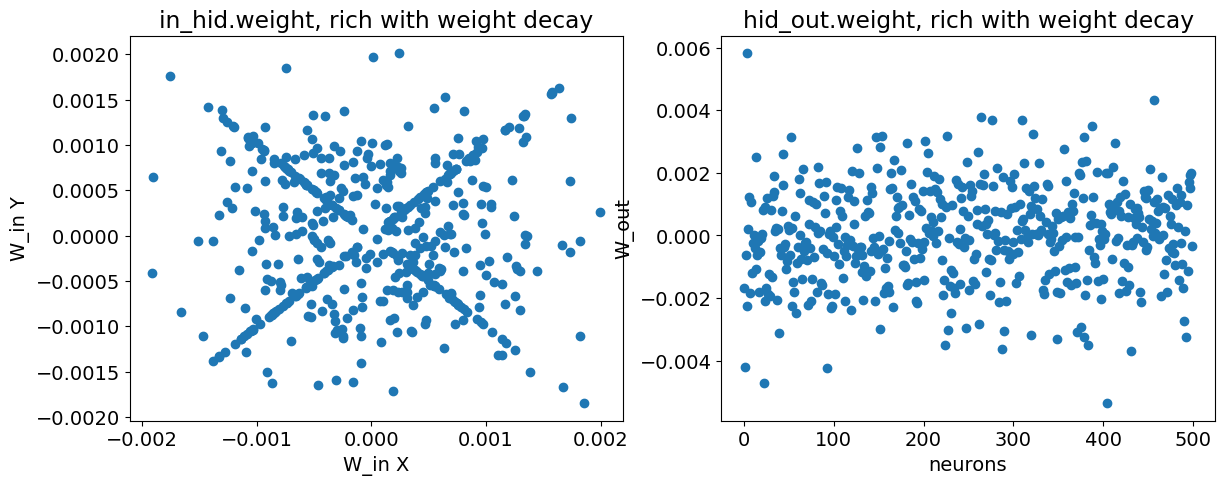

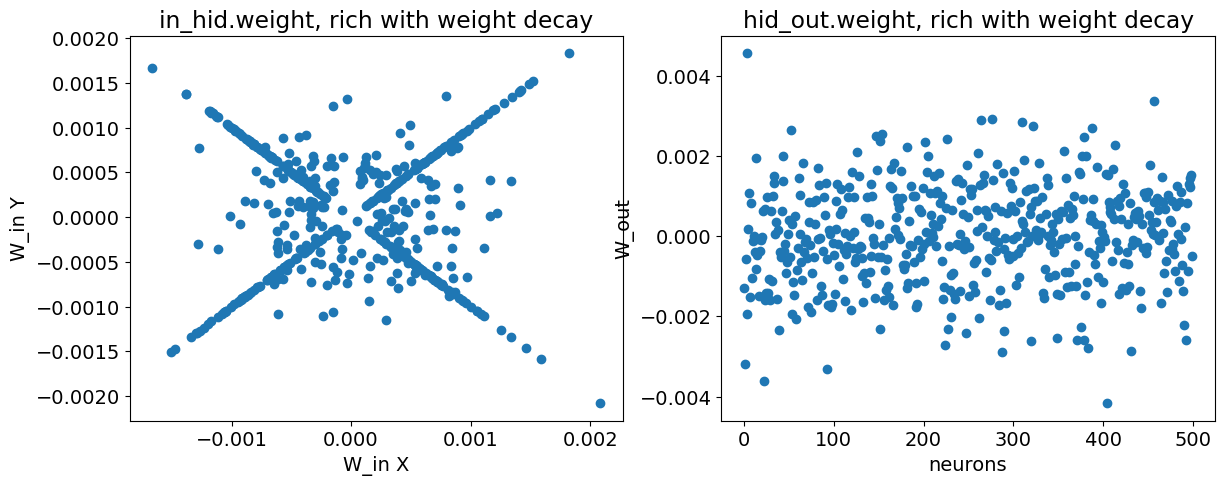

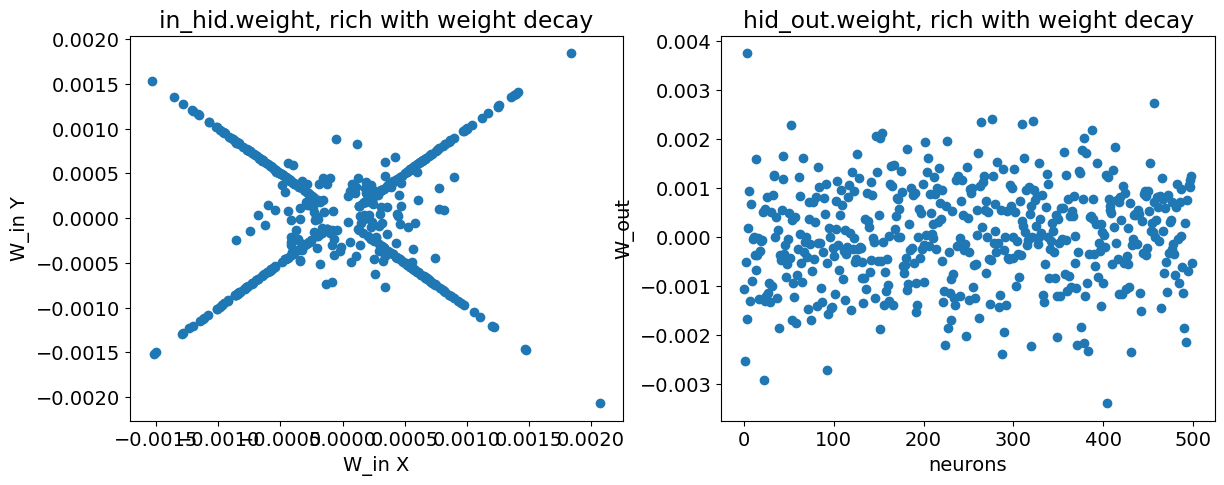

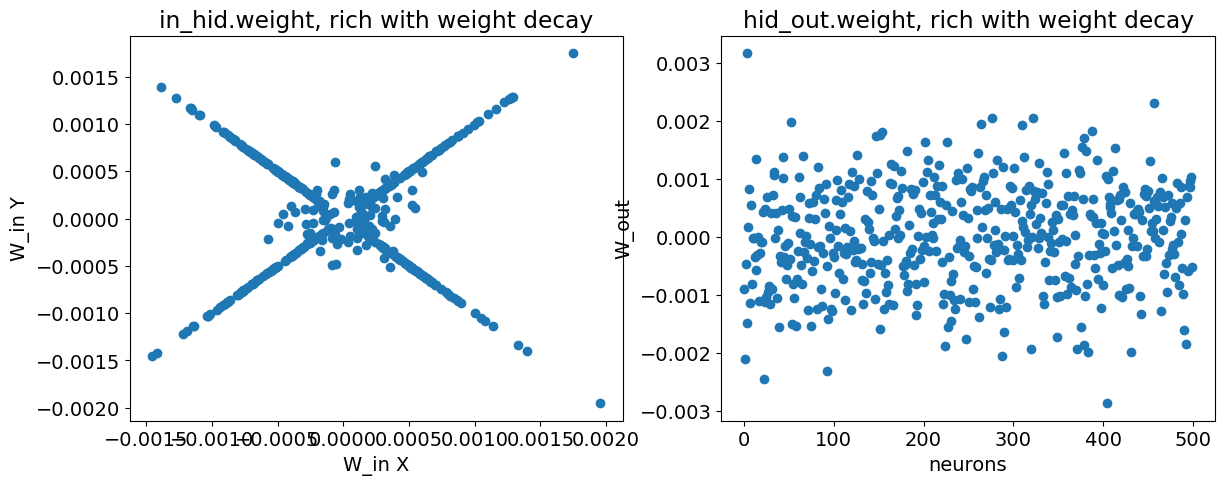

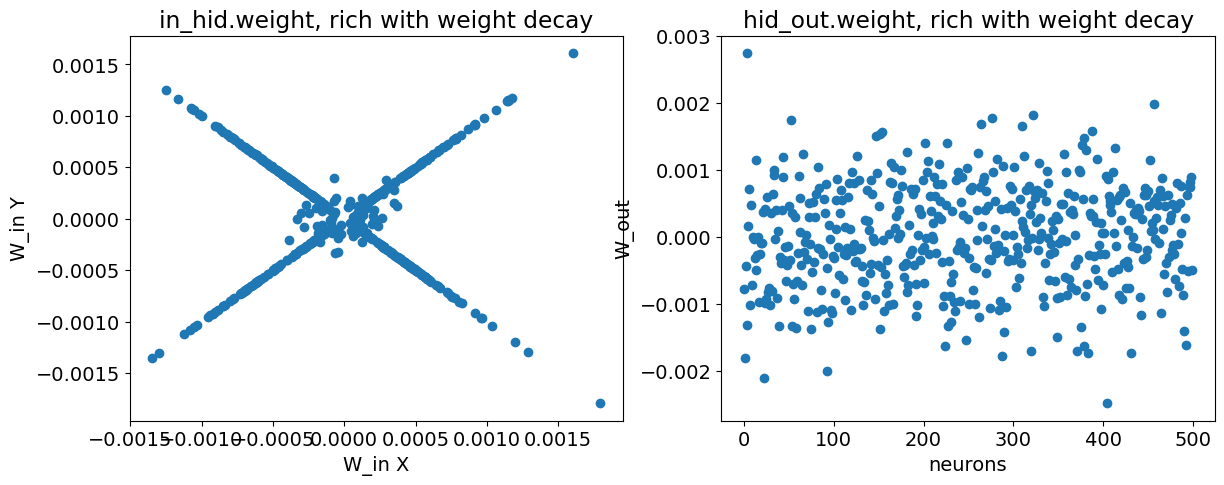

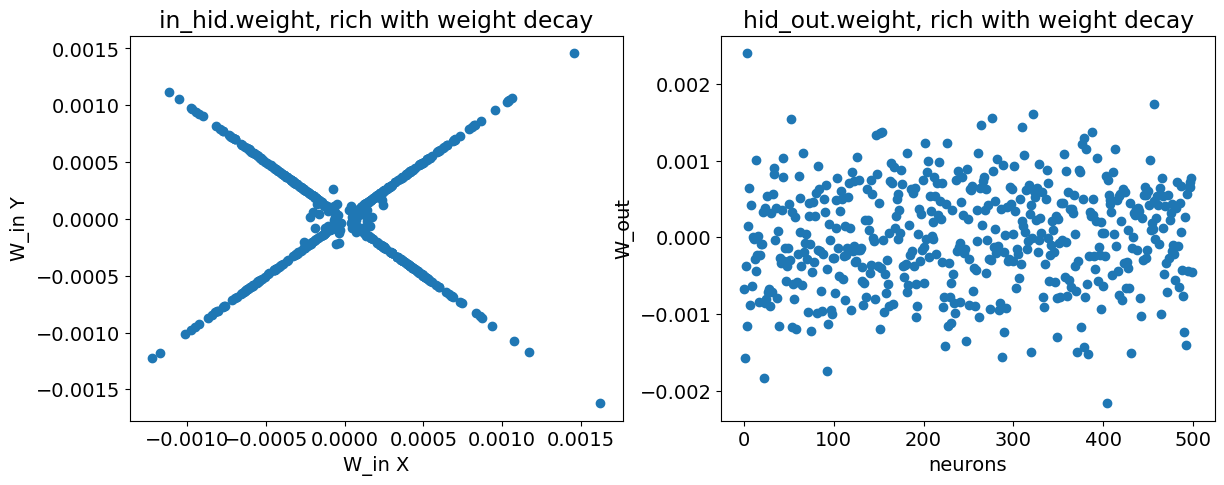

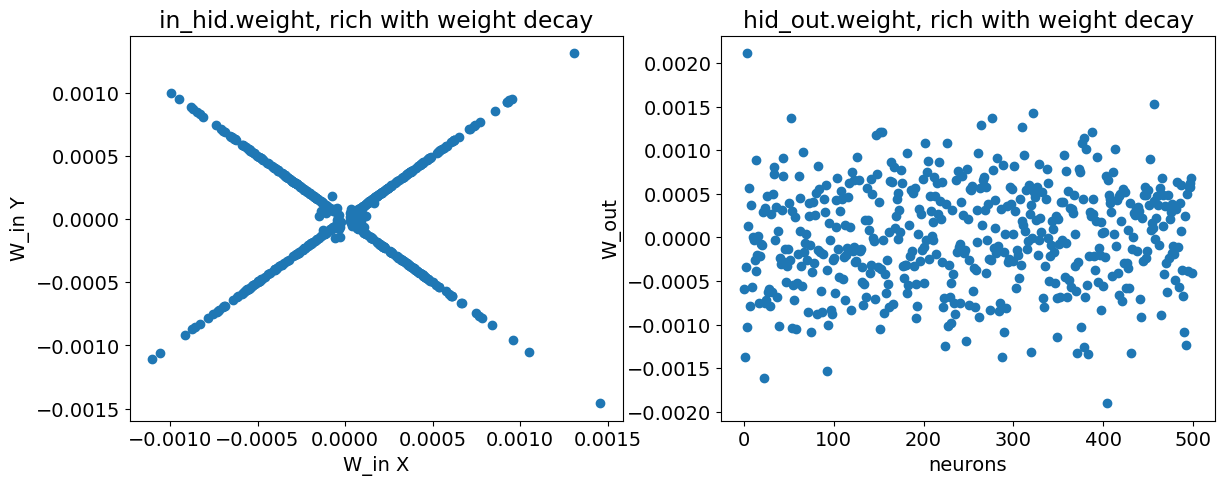

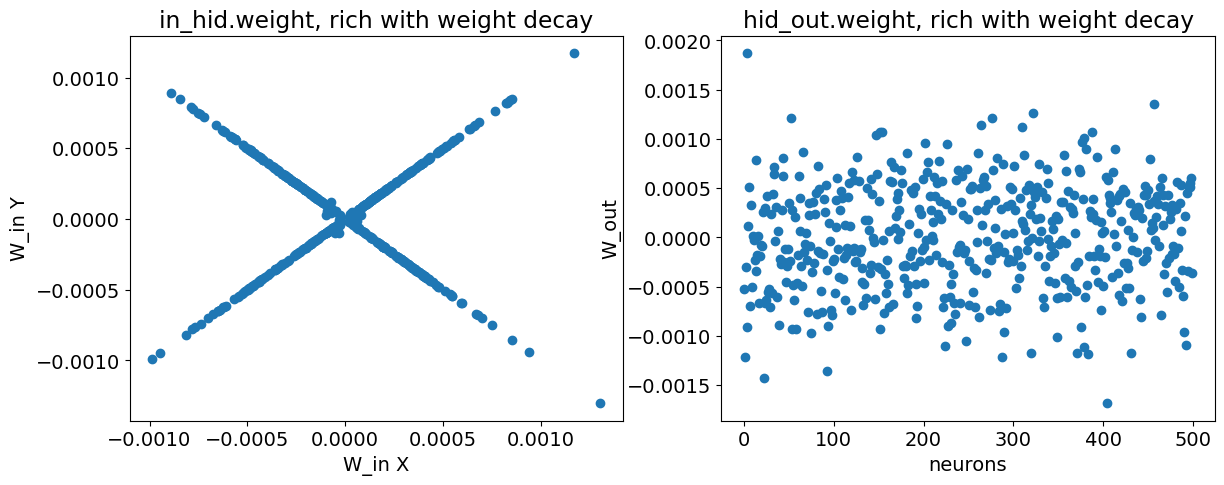

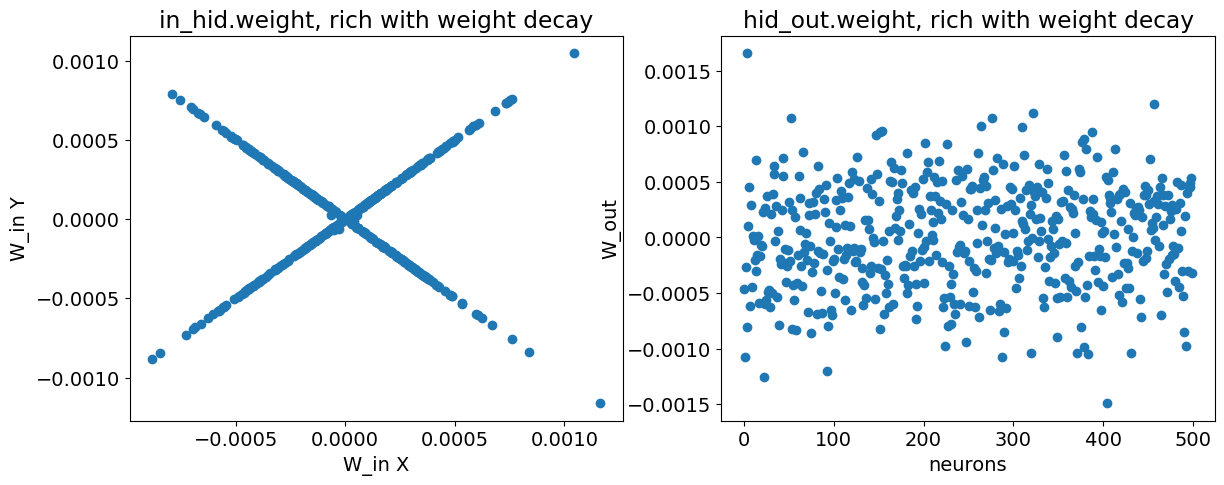

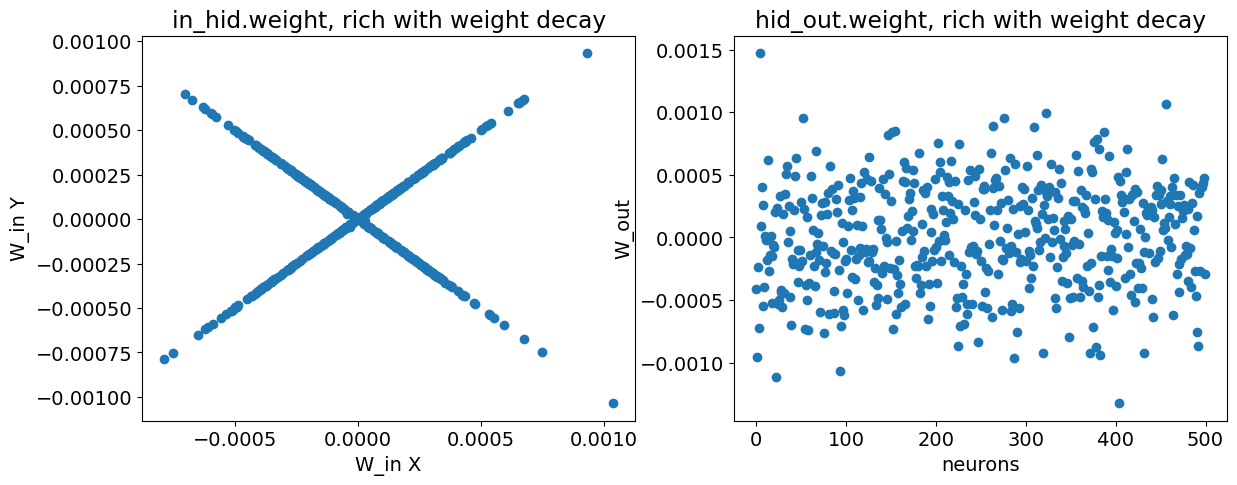

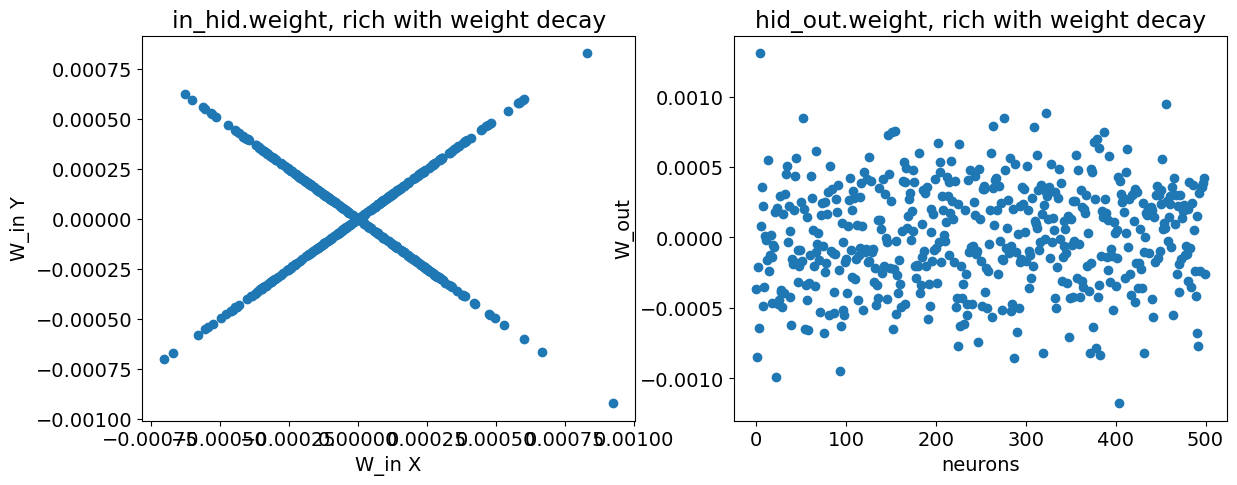

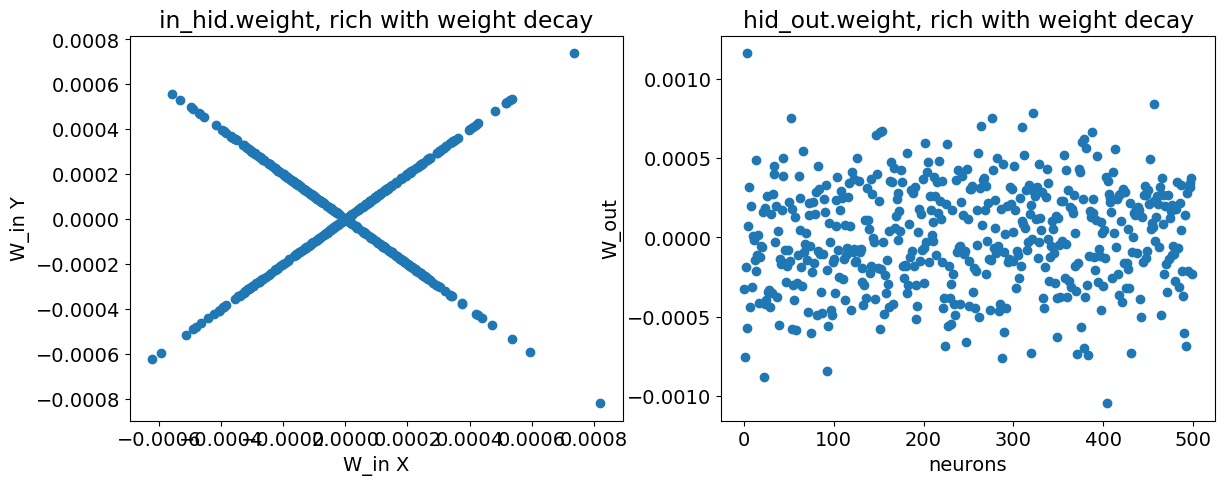

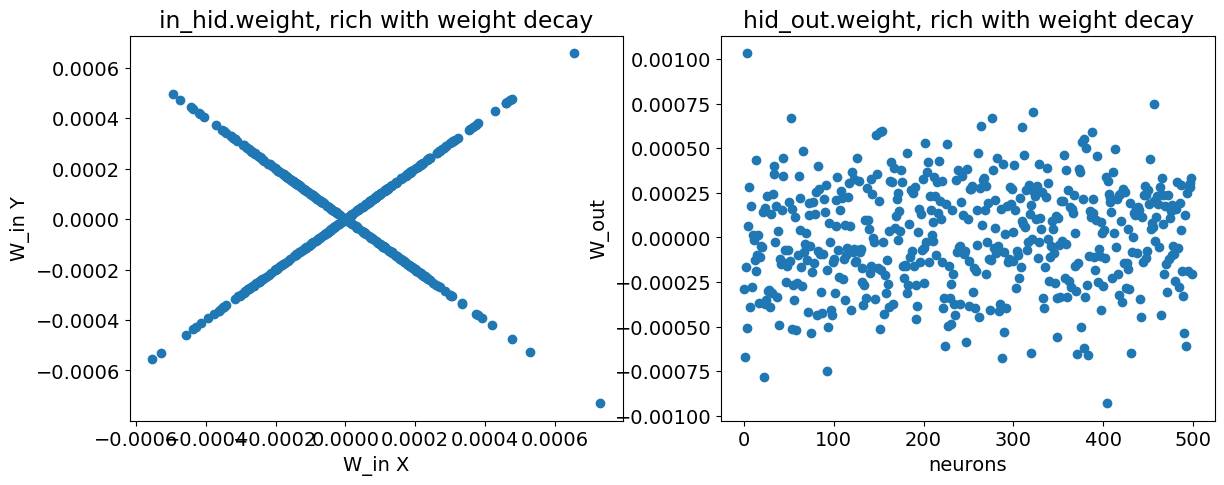

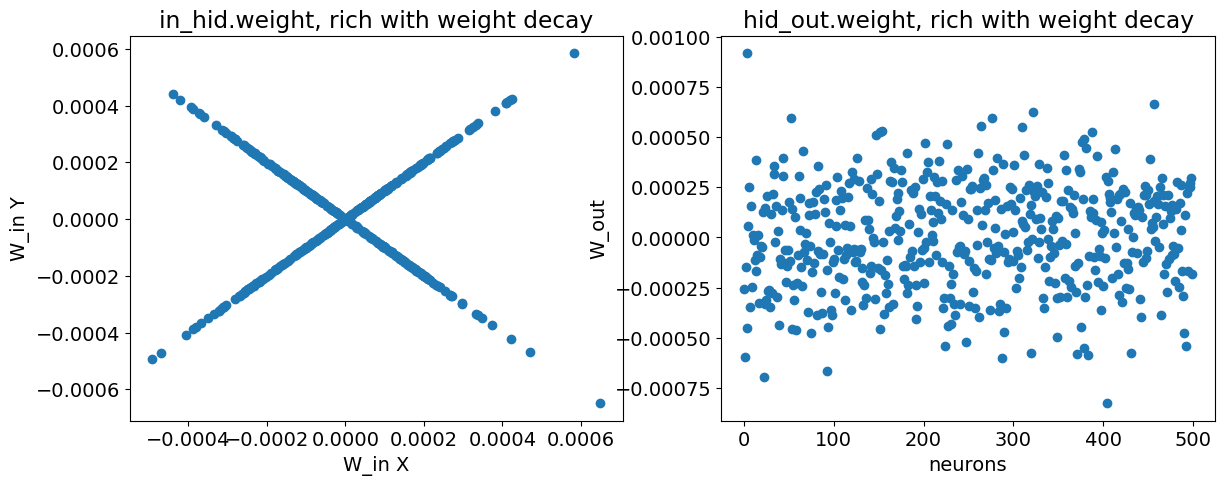

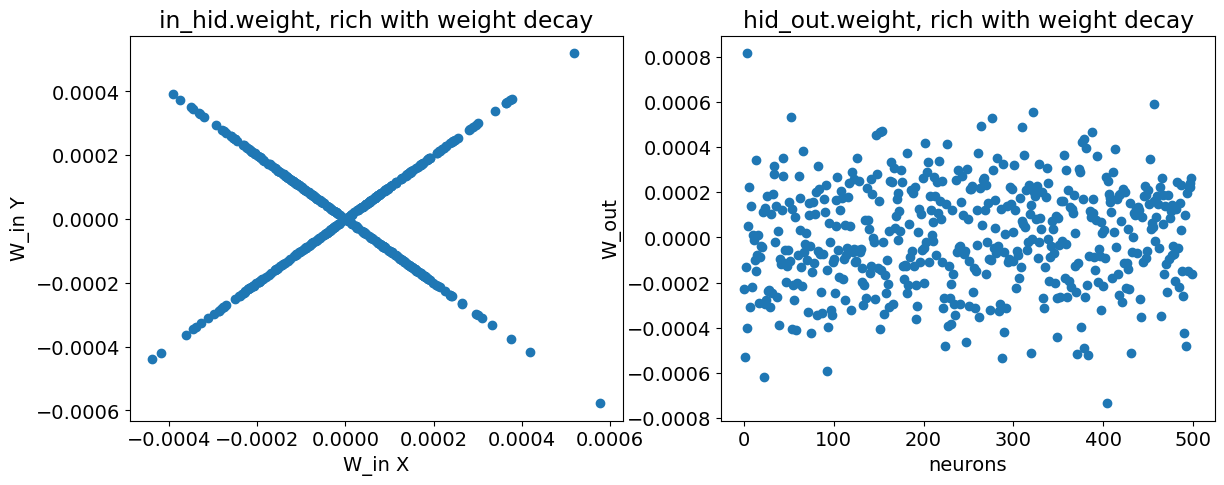

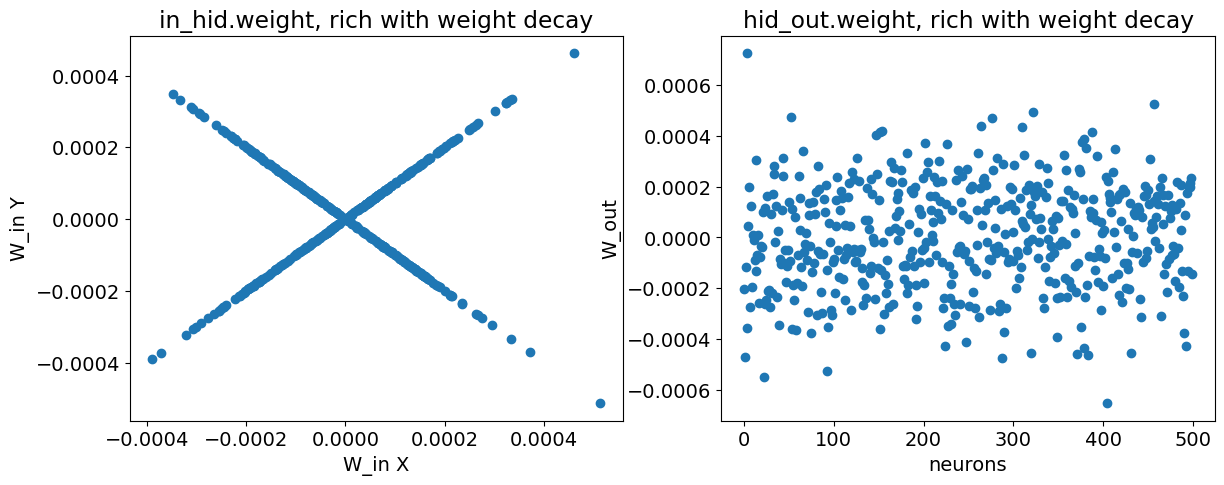

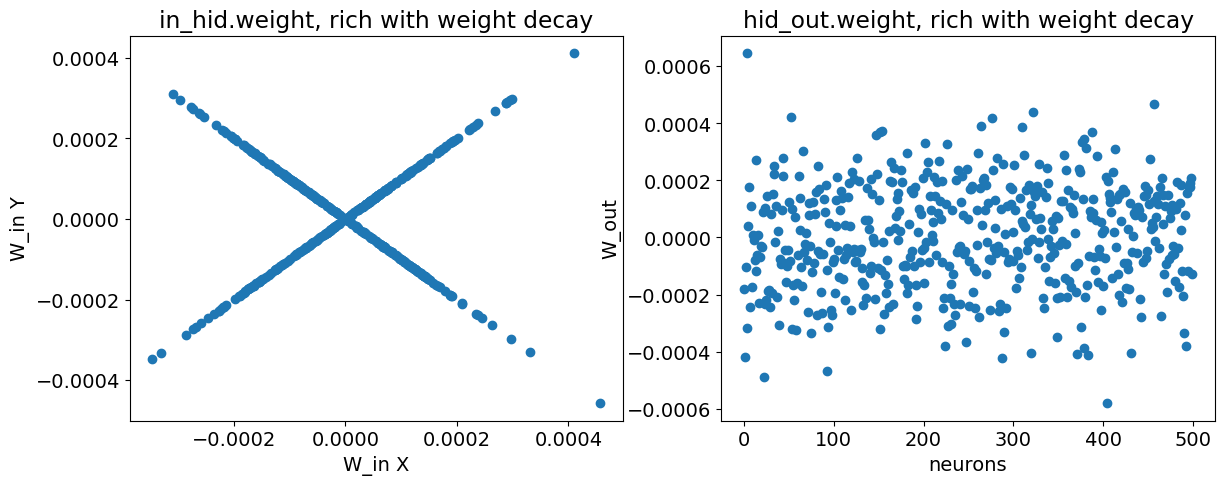

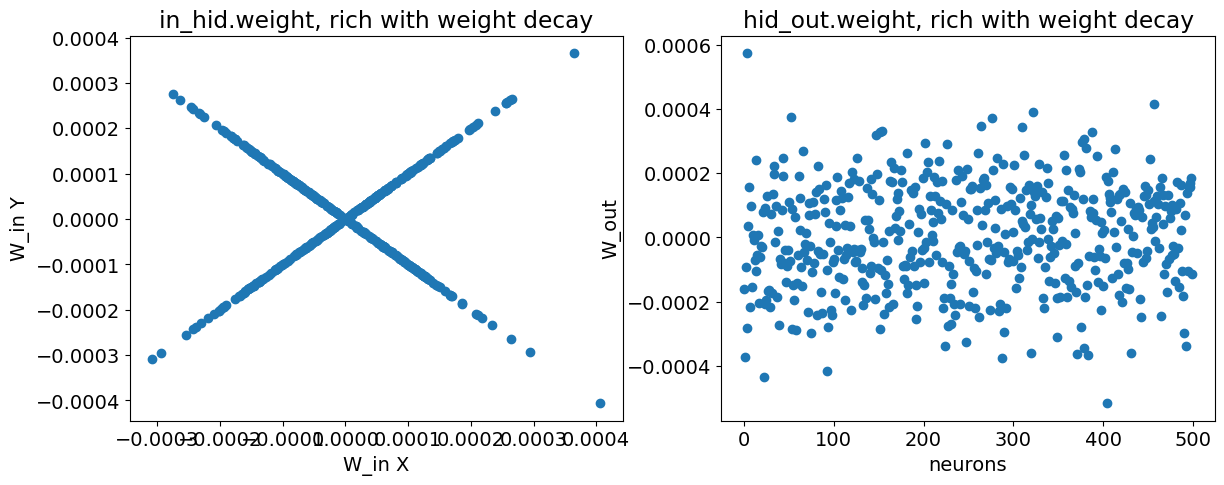

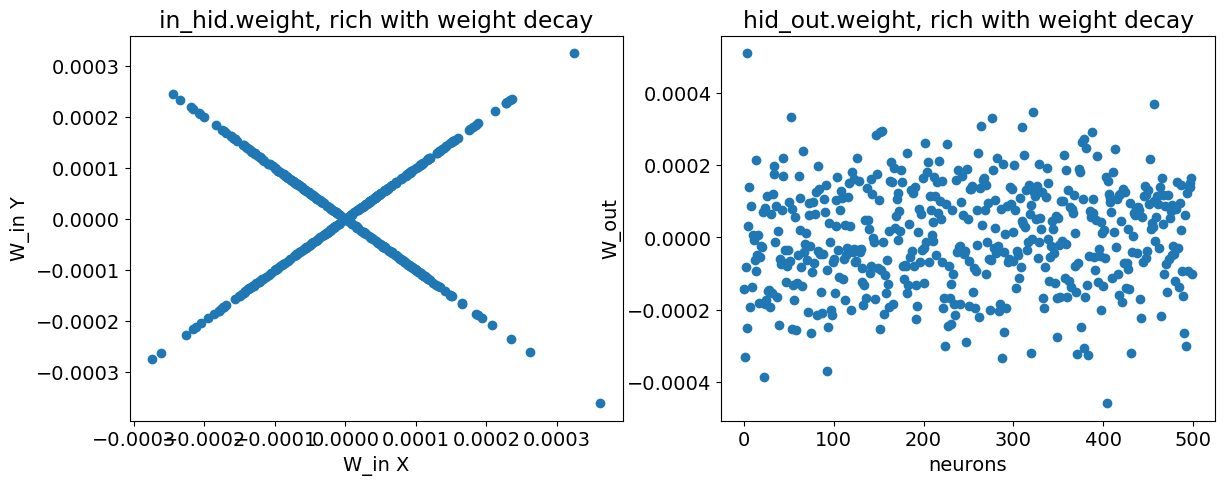

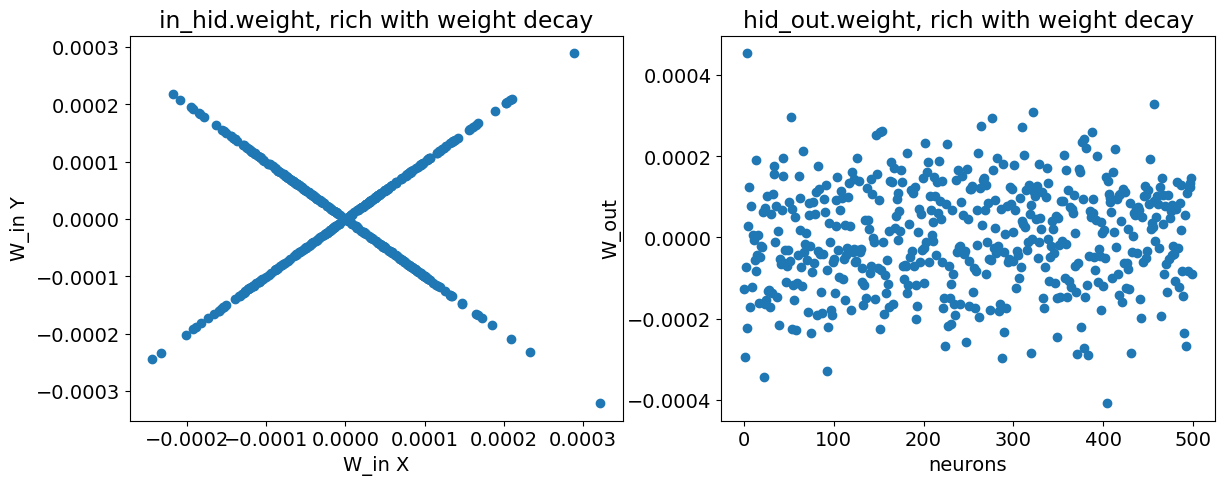

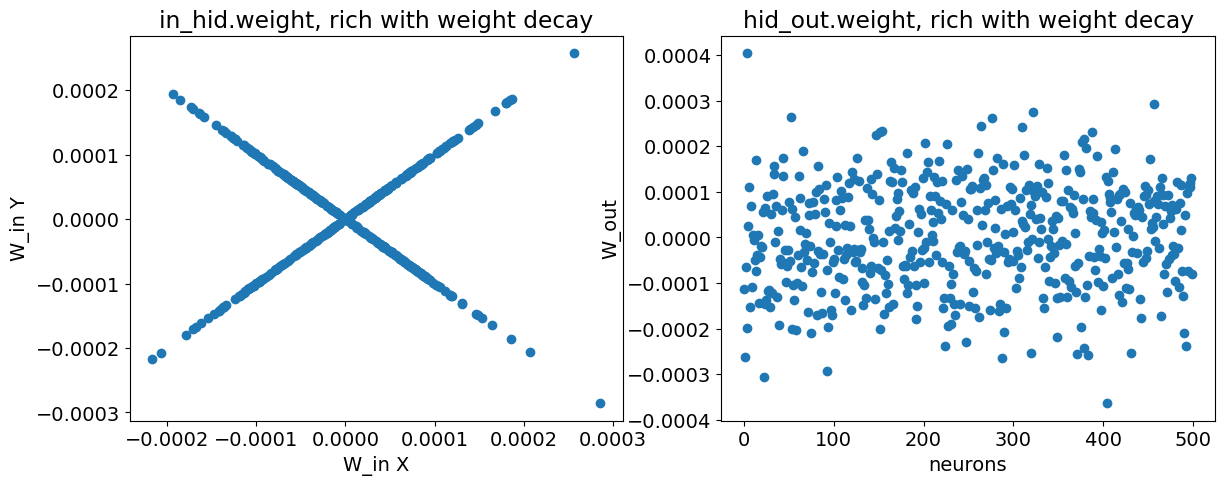

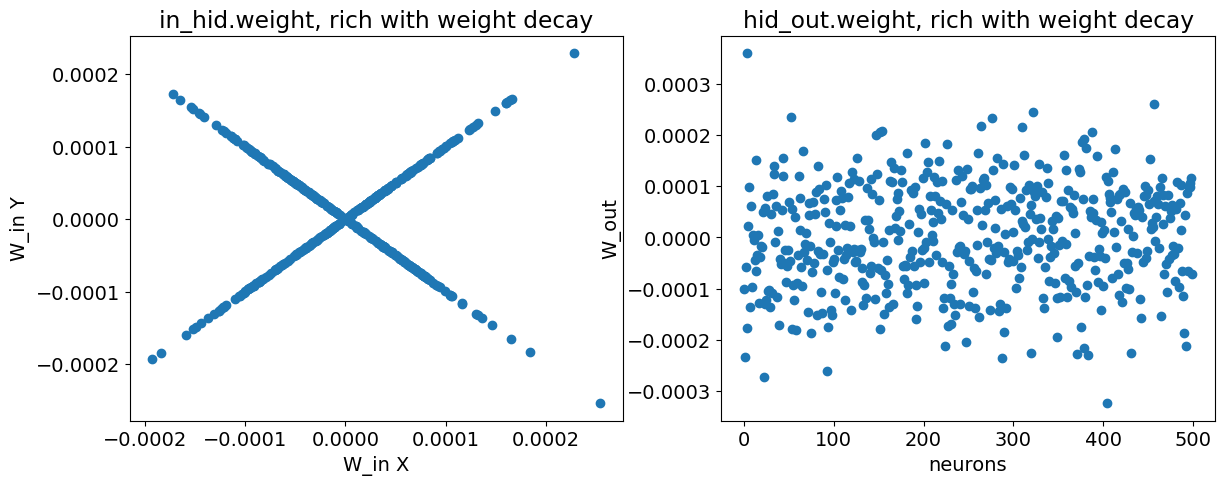

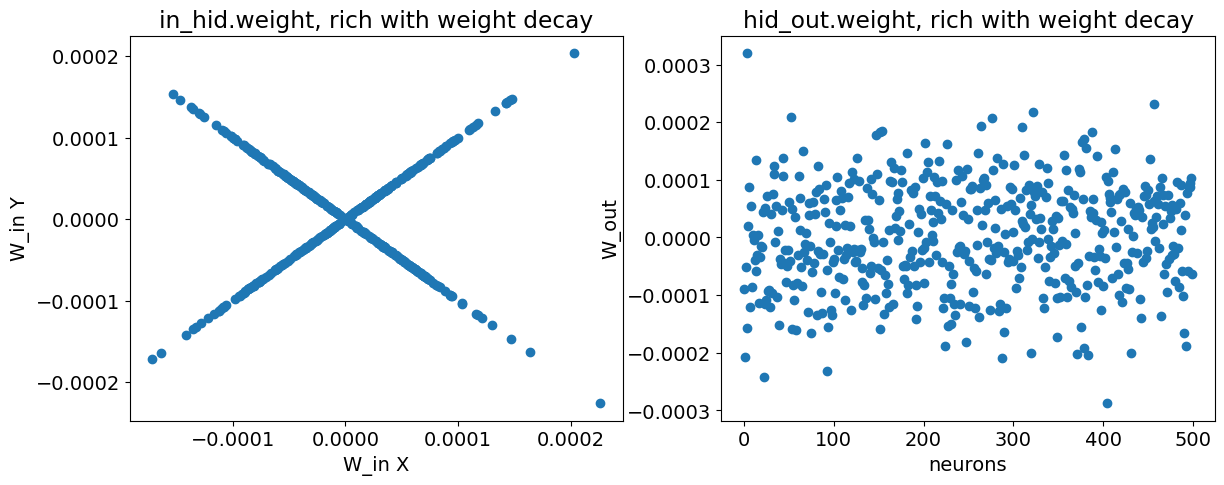

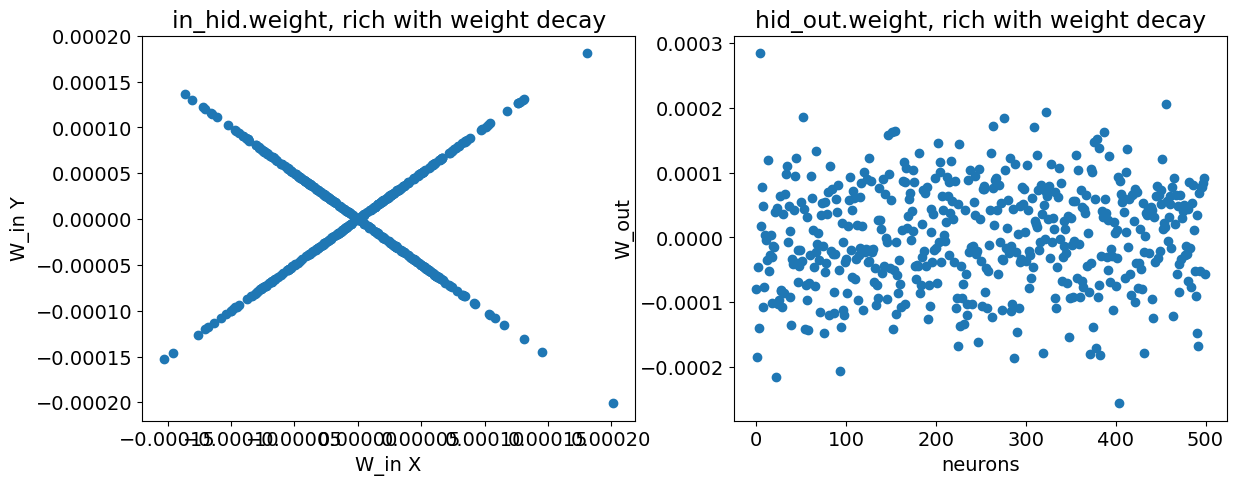

In [120]:
n_epochs = 5000  # Number of epochs
dim_input = 2  # Input dimension = (X, Y)
dim_hidden = 500  # Hidden neurons
dim_output = 1  # Output dimension = Category A or B (0, 1)

lr = 2e-3  # Learning rate
# Initialization scale
w1_init = 0.001
w2_init = 1/dim_hidden

# Weight-decaying parameters
# wd_lambdas = [0, 0.25, 0.5, 1]
wd_lambda = 1

# Training
dlnn_model = LNNet(dim_input, dim_hidden, dim_output, w1_init, w2_init)

optimizer = optim.SGD(dlnn_model.parameters(), lr=lr, weight_decay=wd_lambda)
criterion = nn.MSELoss()

for i in range(n_epochs):
    optimizer.zero_grad()
    y_pred, hiddens = dlnn_model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    
    if i % 200 == 0:
        fig, axes = plt.subplots(1, 2)
        fig.set_size_inches(14, 5)
        for p_i, (name, param) in enumerate(dlnn_model.named_parameters()):
            axis = axes[p_i]
            
            if name == 'in_hid.weight':
                in_hid = param.detach().numpy()
                axis.scatter(in_hid[:, 0], in_hid[:, 1])
                # axis.set_xticks([])
                # axis.set_yticks([])

                axis.set_xlabel('W_in X')
                axis.set_ylabel('W_in Y')
                # axis.set_xlim(-2, 2)
                # axis.set_ylim(-2, 2)
                
                axis.set_title(f'{name}, rich with weight decay')
                
            elif name == 'hid_out.weight':
                hid_out = param.detach().numpy()
                axis.scatter(np.arange(hid_out.shape[1]), hid_out[0])
                
                axis.set_xlabel('neurons')
                axis.set_ylabel('W_out')
                # axis.set_ylim(-0.1, 0.1)
                
                axis.set_title(f'{name}, rich with weight decay')
        
        plt.show()
        # plt.savefig(f'lazy_{i:04d}.png')
        # plt.cla()
        # plt.close()

## Robustnesss vs. Learning speed (stability vs. plasiticity)

In [339]:
x1 = np.array ([-1., -1., 1., 1.], dtype = np.float32)
x2 = np.array ([-1., 1., -1., 1.], dtype = np.float32)
y  = np.array ([-1., 1., 1., -1.],dtype = np.float32)

noisy_X, noisy_y, _, _ = create_dataset(x1, x2, y, n_repeats=5000, noise_lev=5)

In [342]:
criterion = nn.MSELoss()
# w1_inits = [0.001, 0.01, 0.1, 0.5]
model = models[0]

noisy_y_pred = model(noisy_X)[0].detach()

noisy_loss = criterion(noisy_y_pred, noisy_y)
print(noisy_loss)

# noisy_y_pred_class = torch.zeros(noisy_y_pred.shape)
# noisy_y_pred_class[noisy_y_pred > 0] = 1.
# noisy_y_pred_class[noisy_y_pred <= 0] = -1.
# (noisy_y_pred_class == noisy_y).sum() / noisy_y.shape[0]

tensor(10.0452)


Text(0.5, 1.0, 'Noisy inputs')

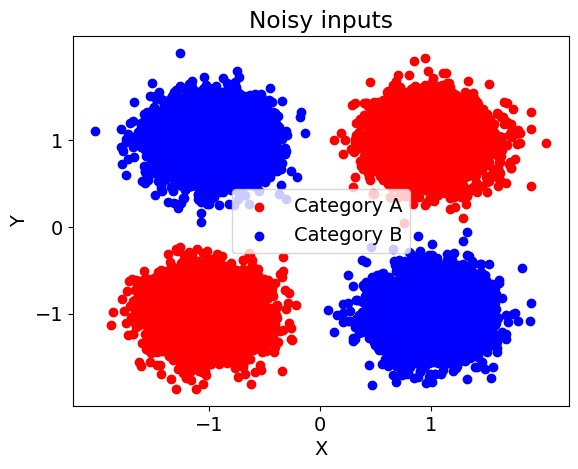

In [328]:
cat_A_idx = (noisy_y_pred_class == -1.)[:, 0]
cat_B_idx = (noisy_y_pred_class == 1.)[:, 0]

plt.scatter(noisy_X[cat_A_idx, 0], noisy_X[cat_A_idx, 1], c = 'r', label = 'Category A')
plt.scatter(noisy_X[cat_B_idx, 0], noisy_X[cat_B_idx, 1], c = 'b', label = 'Category B')
plt.xlabel('X')
plt.ylabel('Y')
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
plt.legend()
plt.title('Noisy inputs')

In [ ]:
for w_i, weight in enumerate(w1_inits):
    model = models[w_i]

## Repeating training of one contingency

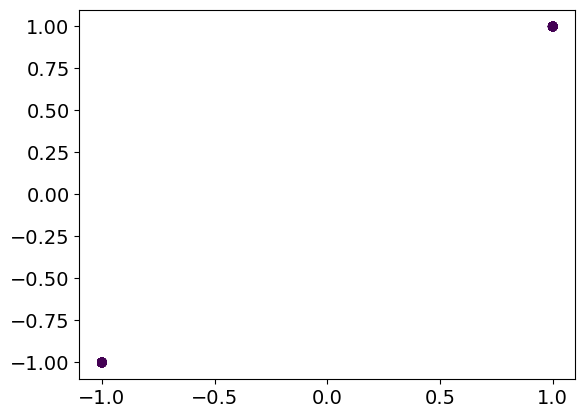

In [122]:
bias_models = []
for model in models:
  bias_models.append(copy.deepcopy(model))

bias_x1 = np.array ([1., -1.], dtype = np.float32)
bias_x2 = np.array ([1., -1.], dtype = np.float32)
bias_y  = np.array ([-1., -1.],dtype = np.float32)
# bias_x1 = np.array ([1.], dtype = np.float32)
# bias_x2 = np.array ([1.], dtype = np.float32)
# bias_y  = np.array ([-1.],dtype = np.float32)
bias_X_train, bias_y_train, bias_X_test, bias_y_test = create_dataset(bias_x1, bias_x2, bias_y, n_repeats=50, noise_lev=0)

plt.scatter(bias_X_train[:, 0], bias_X_train[:, 1], c = bias_y_train)

In [ ]:
n_runs = 1
n_epochs = 5000  # Number of epochs

lr = 2e-3  # Learning rate

bias_losses = np.zeros((2, n_runs, n_epochs))
# Training
for m_i, bias_model in enumerate([bias_models[0], bias_models[-1]]):
  for r_i in range(n_runs):
    bias_loss_per_run, _ = train(bias_model, bias_X_train, bias_y_train, n_epochs=n_epochs, lr=lr)
    bias_losses[m_i, r_i, :] = bias_loss_per_run

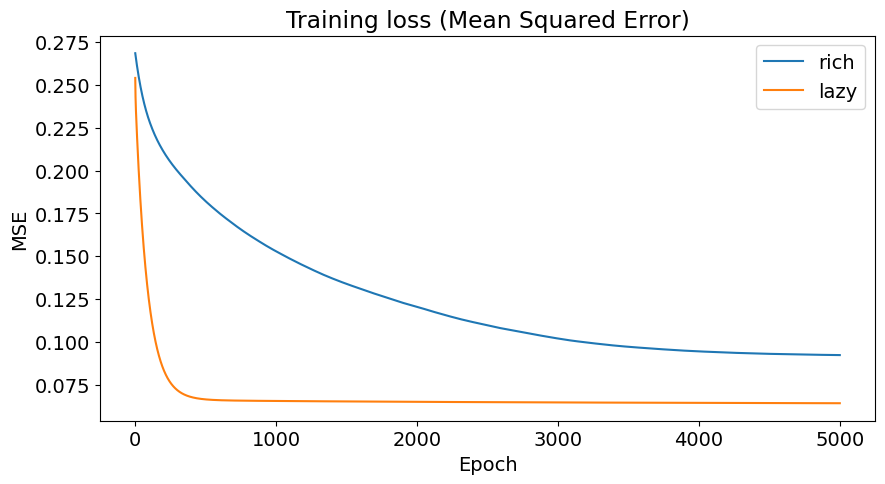

In [ ]:
# Plotting losses
plot_loss(bias_losses, w1_scales=['rich', 'lazy'])

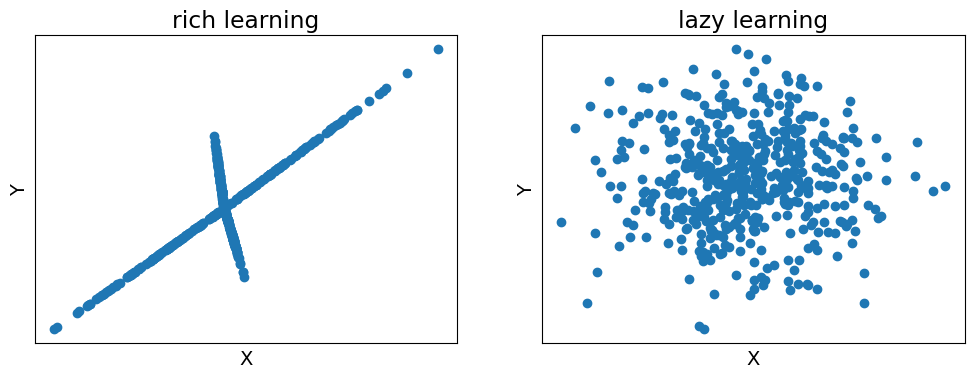

In [ ]:
bias_rich_lazy_models = [bias_models[0], bias_models[-1]]
model_titles = ['rich', 'lazy']

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
for a_i, axis in enumerate(axes):
  model = bias_rich_lazy_models[a_i]
  for name, param in model.named_parameters():
    if name == 'in_hid.weight':
      in_hid = param.detach().numpy()
      axis.scatter(in_hid[:, 0], in_hid[:, 1])
      axis.set_xticks([])
      axis.set_yticks([])
      axis.set_xlabel('X')
      axis.set_ylabel('Y')
      axis.set_title(f'{model_titles[a_i]} learning')

# plt.savefig("rich_lazy_learning_bev_bias.svg")

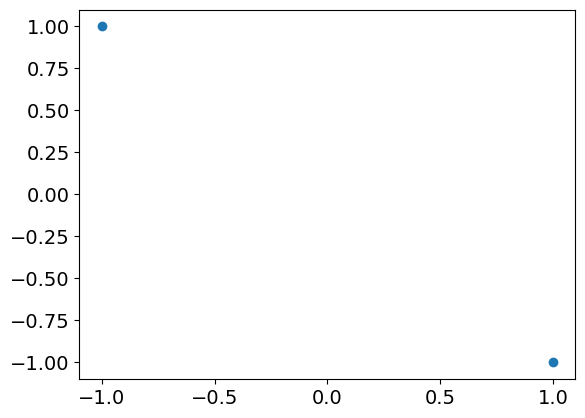

In [ ]:
replay_bias_models = []
for bias_model in bias_models:
  replay_bias_models.append(copy.deepcopy(bias_model))

replay_bias_x1 = np.array ([-1., 1.], dtype = np.float32)
replay_bias_x2 = np.array ([1., -1.], dtype = np.float32)
replay_bias_y  = np.array ([1., 1.],dtype = np.float32)

# replay_bias_x1 = np.array ([-1.], dtype = np.float32)
# replay_bias_x2 = np.array ([-1.], dtype = np.float32)
# replay_bias_y  = np.array ([-1.],dtype = np.float32)

replay_bias_X = torch.tensor([replay_bias_x1, replay_bias_x2]).T
replay_bias_y = torch.tensor(replay_bias_y).unsqueeze(1)
plt.scatter(replay_bias_X[:, 0], replay_bias_X[:, 1])

# replay_bias_X_train, replay_bias_y_train, _, _ = create_dataset(replay_bias_x1, replay_bias_x2, bias_y, n_repeats=50, noise_lev=0)
# plt.scatter(replay_bias_X_train[:, 0], replay_bias_X_train[:, 1], c = replay_bias_y_train)

In [ ]:
n_runs = 1
n_epochs = 5000  # Number of epochs

lr = 2e-3  # Learning rate

replay_bias_losses = np.zeros((2, n_runs, n_epochs))
# Training
for m_i, replay_bias_model in enumerate([replay_bias_models[0], replay_bias_models[-1]]):
  for r_i in range(n_runs):
    replay_bias_loss_per_run, _ = train(replay_bias_model, replay_bias_X, replay_bias_y, n_epochs=n_epochs, lr=lr)
    replay_bias_losses[m_i, r_i, :] = replay_bias_loss_per_run

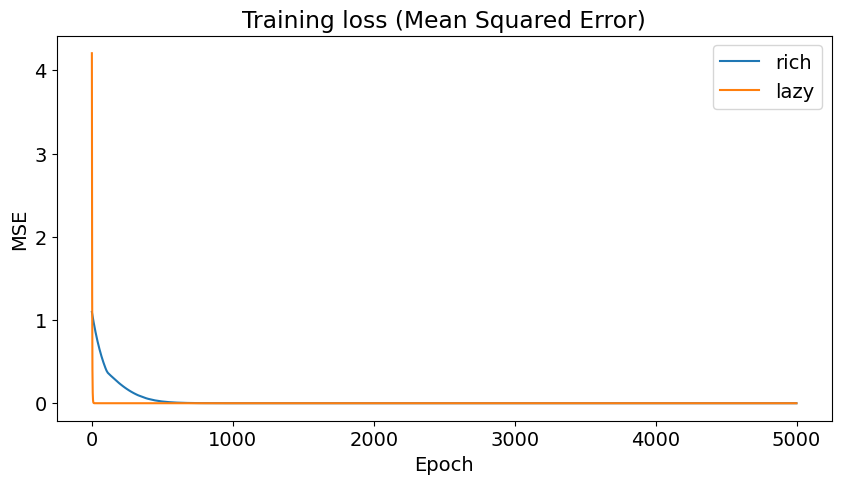

In [ ]:
# Plotting losses
plot_loss(replay_bias_losses, w1_scales=['rich', 'lazy'])

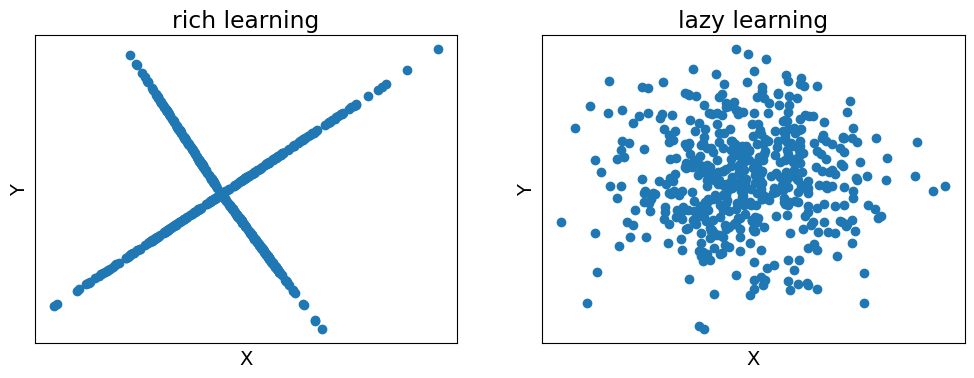

In [ ]:
replay_bias_rich_lazy_models = [replay_bias_models[0], replay_bias_models[-1]]
model_titles = ['rich', 'lazy']

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
for a_i, axis in enumerate(axes):
  model = replay_bias_rich_lazy_models[a_i]
  for name, param in model.named_parameters():
    if name == 'in_hid.weight':
      in_hid = param.detach().numpy()
      axis.scatter(in_hid[:, 0], in_hid[:, 1])
      axis.set_xticks([])
      axis.set_yticks([])
      axis.set_xlabel('X')
      axis.set_ylabel('Y')
      axis.set_title(f'{model_titles[a_i]} learning')

# plt.savefig("rich_lazy_learning_after_replay_bias.svg")